# iclr

### looping fix

gamma: 0.9900498337491681
Ep    1 | return   -393.0 | α 1.000 | Time: 1.59s
Ep    2 | return   -595.6 | α 0.958 | Time: 9.71s
Ep    3 | return   -746.1 | α 0.902 | Time: 17.18s
Ep    4 | return   -681.7 | α 0.850 | Time: 24.65s
Ep    5 | return   -702.0 | α 0.801 | Time: 31.69s
Ep    6 | return   -427.9 | α 0.755 | Time: 38.85s
Ep    7 | return   -536.7 | α 0.715 | Time: 45.89s
Ep    8 | return   -536.2 | α 0.680 | Time: 53.34s
Ep    9 | return   -643.5 | α 0.648 | Time: 60.84s
Ep   10 | return   -734.0 | α 0.616 | Time: 67.73s
Ep   11 | return   -693.1 | α 0.585 | Time: 75.28s
Ep   12 | return   -595.5 | α 0.560 | Time: 83.31s
Ep   13 | return   -609.6 | α 0.543 | Time: 90.98s
Ep   14 | return   -554.7 | α 0.527 | Time: 98.17s
Ep   15 | return   -562.8 | α 0.511 | Time: 105.33s
Ep   16 | return   -416.0 | α 0.491 | Time: 112.47s
Ep   17 | return   -514.5 | α 0.475 | Time: 119.86s
Ep   18 | return   -488.8 | α 0.461 | Time: 126.95s
Ep   19 | return   -463.5 | α 0.447 | Time: 134.27s
Ep

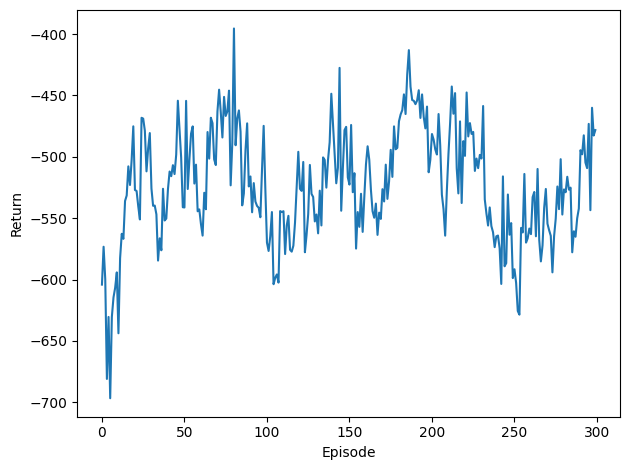

In [1]:
# sac_pendulum.py
# ------------------------------------------------------------
#  Soft Actor–Critic (v2, no separate V-network) for Pendulum-v1
# ------------------------------------------------------------
import math, random, time, collections, os, argparse
from itertools import count
from types import SimpleNamespace   # handy stand-in for argparse.Namespace
from time import time

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------
#  Hyper-parameters (override from CLI if you like)
# ------------------------------------------------------------
# def get_args():
#     p = argparse.ArgumentParser()
#     p.add_argument("--env",           default="Pendulum-v1")
#     p.add_argument("--episodes",      type=int,   default=300)
#     p.add_argument("--steps-per-ep",  type=int,   default=200)   # T
#     p.add_argument("--batch",         type=int,   default=256)
#     p.add_argument("--replay",        type=int,   default=50_000)
#     p.add_argument("--start-steps",   type=int,   default=1_000) # random policy steps
#     p.add_argument("--updates-per-step", type=int, default=1)
#     p.add_argument("--gamma",         type=float, default=0.99)
#     p.add_argument("--tau",           type=float, default=0.005) # soft-update rate
#     p.add_argument("--lr",            type=float, default=3e-4)
#     p.add_argument("--hidden",        type=int,   default=256)
#     p.add_argument("--seed",          type=int,   default=0)
#     p.add_argument("--target-entropy",type=float, default=None,  # set automatically
#                    help="If None, use −|A| by default")
#     return p.parse_args()

# ------------------------------------------------------------
#  Replay buffer
# ------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim, device):
        self.device = device
        self.capacity = capacity
        self.ptr = 0
        self.size = 0
        self.obs_buf  = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.act_buf  = torch.zeros((capacity, act_dim),  dtype=torch.float32, device=device)
        self.rew_buf  = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)
        self.next_buf = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.done_buf = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]   = torch.as_tensor(obs,  device=self.device)
        self.act_buf[self.ptr]   = torch.as_tensor(act,  device=self.device)
        self.rew_buf[self.ptr]   = torch.as_tensor([rew],device=self.device)
        self.next_buf[self.ptr]  = torch.as_tensor(next_obs, device=self.device)
        self.done_buf[self.ptr]  = torch.as_tensor([done],device=self.device)

        self.ptr  = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return ( self.obs_buf[idx],
                 self.act_buf[idx],
                 self.rew_buf[idx],
                 self.next_buf[idx],
                 self.done_buf[idx] )

# ------------------------------------------------------------
#  Helper nets
# ------------------------------------------------------------
LOG_STD_MIN, LOG_STD_MAX = -5.0, 2.0

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),  nn.ReLU())
        self.mean  = nn.Linear(hidden, act_dim)
        self.logsd = nn.Linear(hidden, act_dim)
        self.max_action = max_action

    def _dist(self, obs):
        h = self.net(obs)
        mu = self.mean(h)
        log_std = torch.clamp(self.logsd(h), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std, log_std

    def forward(self, obs):
        mu, std, log_std = self._dist(obs)
        eps = torch.randn_like(std)
        pre_tanh = mu + std * eps  # reparameterisation
        action = torch.tanh(pre_tanh)
        logp = (
            -0.5 * ((pre_tanh - mu) / std).pow(2)
            - log_std
            - 0.5 * math.log(2 * math.pi)
        ).sum(-1, keepdim=True)
        # change-of-variables for tanh: see Appendix C in SAC paper
        logp -= torch.log(1 - action.pow(2) + 1e-6).sum(-1, keepdim=True)
        return action * self.max_action, logp  # scaled to env bounds

    def act(self, obs, deterministic=False):
        with torch.no_grad():
            if deterministic:
                # _dist returns (mu, std, log_std)
                mu, _, _ = self._dist(obs)          # <-- fix here
                action = torch.tanh(mu) * self.max_action
                return action
            else:
                a, _ = self.forward(obs)
                return a

    # def act(self, obs, deterministic=False):
    #     with torch.no_grad():
    #         if deterministic:
    #             mu, _ = self._dist(obs)
    #             action = torch.tanh(mu) * self.max_action
    #             return action
    #         else:
    #             a, _ = self.forward(obs)
    #             return a

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden):
        super().__init__()
        self.Q1 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))
        self.Q2 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.Q1(x), self.Q2(x)

# ------------------------------------------------------------
#  SAC Agent
# ------------------------------------------------------------
class SACAgent:
    def __init__(self, obs_dim, act_dim, max_action, args, device):
        self.device = device
        self.actor  = Actor(obs_dim, act_dim, args.hidden, max_action).to(device)
        self.critic = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target.load_state_dict(self.critic.state_dict())

        self.actor_opt  = torch.optim.Adam(self.actor.parameters(),  lr=args.lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=args.lr)

        # entropy temperature
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=device)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=args.lr)
        self.target_entropy = ( -act_dim if args.target_entropy is None
                                else args.target_entropy )

        self.gamma = args.gamma
        self.tau   = args.tau
        self.max_action = max_action

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def update(self, replay, batch_size):
        obs, act, rew, next_obs, done = replay.sample(batch_size)
        # ----- critic -----
        with torch.no_grad():
            next_act, next_logp = self.actor(next_obs)
            tq1, tq2 = self.target(next_obs, next_act)
            tq = torch.min(tq1, tq2) - self.alpha * next_logp
            target_Q = rew + self.gamma * (1 - done) * tq

        cur_q1, cur_q2 = self.critic(obs, act)
        critic_loss = F.mse_loss(cur_q1, target_Q) + F.mse_loss(cur_q2, target_Q)

        self.critic_opt.zero_grad(set_to_none=True)
        critic_loss.backward()
        self.critic_opt.step()

        # ----- actor -----
        new_act, logp = self.actor(obs)
        q1_pi, q2_pi = self.critic(obs, new_act)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * logp - q_pi).mean()

        self.actor_opt.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor_opt.step()

        # ----- temperature -----
        alpha_loss = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(set_to_none=True)
        alpha_loss.backward()
        self.alpha_opt.step()

        # ----- soft update target -----
        with torch.no_grad():
            for p, tp in zip(self.critic.parameters(), self.target.parameters()):
                tp.data.lerp_(p.data, self.tau)


def _default_dt(env, fallback=0.02):
    return getattr(env.unwrapped, "tau", fallback)

from typing import Optional
import numpy as np

try:
    import torch
    _HAS_TORCH = True
except Exception:
    _HAS_TORCH = False


def obs_to_state_pendulum(
    obs,
    *,
    normalize: bool = True,
    prev_theta: Optional[object] = None,
):
    """
    Convert Pendulum-v1 observation(s) [cos(theta), sin(theta), theta_dot]
    to state(s) [theta, theta_dot].

    Args
    ----
    obs: np.ndarray | torch.Tensor
        Shape (..., 3). Works batched or unbatched.
    normalize: bool
        If True, re-normalize (cos, sin) to unit length before atan2.
        Helps when numbers drift slightly due to noise/precision.
    prev_theta: same type/shape as theta or broadcastable to it, optional
        If provided, unwraps the angle to be continuous near prev_theta.
        Useful for time series.

    Returns
    -------
    state: np.ndarray | torch.Tensor
        Shape (..., 2) with [theta, theta_dot], same type/device/dtype as input.
    """
    is_torch = _HAS_TORCH and isinstance(obs, torch.Tensor)

    if is_torch:
        if obs.shape[-1] != 3:
            raise ValueError(f"Expected last dim=3, got {obs.shape}.")
        cos_t, sin_t, theta_dot = obs[..., 0], obs[..., 1], obs[..., 2]

        if normalize:
            r = torch.sqrt(cos_t * cos_t + sin_t * sin_t).clamp_min(1e-8)
            cos_t, sin_t = cos_t / r, sin_t / r

        theta = torch.atan2(sin_t, cos_t)

        if prev_theta is not None:
            prev_theta = torch.as_tensor(prev_theta, dtype=theta.dtype, device=theta.device)
            two_pi = torch.tensor(2 * np.pi, dtype=theta.dtype, device=theta.device)
            pi = torch.tensor(np.pi, dtype=theta.dtype, device=theta.device)
            delta = (theta - prev_theta + pi) % two_pi - pi
            theta = prev_theta + delta

        return torch.stack([theta, theta_dot], dim=-1)

    # NumPy path
    obs = np.asarray(obs)
    if obs.shape[-1] != 3:
        raise ValueError(f"Expected last dim=3, got {obs.shape}.")
    cos_t, sin_t, theta_dot = obs[..., 0], obs[..., 1], obs[..., 2]

    if normalize:
        r = np.sqrt(cos_t * cos_t + sin_t * sin_t)
        r = np.maximum(r, 1e-8)
        cos_t, sin_t = cos_t / r, sin_t / r

    theta = np.arctan2(sin_t, cos_t)

    if prev_theta is not None:
        prev_theta = np.asarray(prev_theta)
        delta = (theta - prev_theta + np.pi) % (2 * np.pi) - np.pi
        theta = prev_theta + delta

    return np.stack([theta, theta_dot], axis=-1)


@torch.no_grad()
def evaluate_policy(agent_or_actor, args, env, *, deterministic=True, use_brownian=True):
    """
    Evaluate a (deterministic) policy on Pendulum-v1 with optional Brownian
    perturbation on the *internal state* [theta, theta_dot] after each step.

    agent_or_actor: SACAgent or Actor
    args: expects args.eval_num_traj, args.eval_traj_len, args.gamma, args.dt, args.sigma
    env: gymnasium Pendulum-v1 env
    deterministic: use actor mean action (tanh(mu)) if True
    use_brownian: apply state diffusion with sigma*sqrt(dt) if True
    """
    # accept SACAgent or raw Actor
    actor = getattr(agent_or_actor, "actor", agent_or_actor)
    dev = next(actor.parameters()).device if isinstance(actor, torch.nn.Module) else device

    actor.eval()
    returns = []

    for _ in range(args.eval_num_traj):
        obs, _ = env.reset()
        ep_ret = 0.0

        # keep a continuous angle for nicer unwrapping during diffusion
        # initialize from the reset observation
        theta0 = obs_to_state_pendulum(obs)[0]  # [theta, theta_dot] -> take theta
        prev_theta = float(theta0)

        for t in range(args.eval_traj_len):
            s = torch.as_tensor(obs, device=dev, dtype=torch.float32).unsqueeze(0)  # [1, 3]
            a = actor.act(s, deterministic=deterministic).squeeze(0).cpu().numpy()  # [1] -> ()

            obs2, r, term, trunc, _ = env.step(a)
            ep_ret += float(r) * (args.gamma ** t)

            if use_brownian and getattr(args, "sigma", 0.0) > 0.0:
                # convert new observation to [theta, theta_dot], diffuse, and write back to env.state
                st = torch.as_tensor(
                    obs_to_state_pendulum(obs2, prev_theta=prev_theta),
                    dtype=torch.float32, device=dev
                )  # shape [2] = [theta, theta_dot]

                dW = torch.randn_like(st) * math.sqrt(args.dt)
                st_n = st + args.sigma * dW  # diffuse in state space

                # write back to env's internal state (Pendulum expects [theta, theta_dot])
                env.unwrapped.state = st_n.detach().cpu().numpy().copy()
                prev_theta = float(st_n[0].item())

                # refresh observation to stay consistent with env.state
                try:
                    obs = env.unwrapped._get_obs().astype(np.float32)
                except Exception:
                    theta, theta_dot = float(st_n[0].item()), float(st_n[1].item())
                    obs = np.array([math.cos(theta), math.sin(theta), theta_dot], dtype=np.float32)
            else:
                obs = obs2

            if term or trunc:
                break

        returns.append(ep_ret)

    actor.train()
    return float(np.mean(returns))


# ------------------------------------------------------------
#  Training loop
# ------------------------------------------------------------
def main():

    ENV = "Pendulum-v1"
    env = gym.make(ENV)
    # args = get_args()
    args = SimpleNamespace(
        env              = ENV,
        episodes         = 300,
        steps_per_ep     = 200,        # T
        batch            = 256,
        replay           = 50_0,
        start_steps      = 100,      # random policy steps
        updates_per_step = 1,
        
        gamma            = None,
        rho              = 0.5,
        dt               = _default_dt(env),
        
        tau              = 0.005,      # soft-update rate
        lr               = 3e-4,
        hidden           = 256,
        seed             = 0,
        sigma            = 0.1, 
        target_entropy   = None,       # if None, = −|A|

        # Evaluation ------------------------------------------------------------
        eval_traj_len   = 500,
        eval_num_traj   = 10,
    )
    args.gamma = math.exp(- args.rho * args.dt)
    print('gamma:', args.gamma)


    results_dir = f"results/ms-iclr/sac/pendulum_sigma={args.sigma}_eval_traj_len={args.eval_num_traj}_num_steps={args.steps_per_ep}_outer{args.episodes}_rho={args.rho}_countingtime"
    os.makedirs(results_dir, exist_ok=True)
    
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    obs_dim = env.observation_space.shape[0]          # 3
    act_dim = env.action_space.shape[0]               # 1
    max_action = float(env.action_space.high[0])

    replay = ReplayBuffer(args.replay, obs_dim, act_dim, device)
    agent  = SACAgent(obs_dim, act_dim, max_action, args, device)

    episode_returns = []
    global_steps = 0

    start = time()

    for ep in range(1, args.episodes + 1):
        obs, _ = env.reset(seed=args.seed + ep)
        ep_ret, ep_steps = 0.0, 0

        for t in range(args.steps_per_ep):
            # --- act ---
            if global_steps < args.start_steps:
                act = env.action_space.sample()
            else:
                act = agent.actor.act(torch.as_tensor(obs, device=device).unsqueeze(0))
                act = act.squeeze(0).cpu().numpy()

            next_obs, reward, terminated, truncated, _ = env.step(act)
            done = terminated or truncated


            # --- add stochastic diffusion ---
            #  convert to torch on the right device
            st = torch.as_tensor(obs_to_state_pendulum(next_obs), dtype=torch.float32, device=device)
            
            # ΔW ~ N(0, dt * I)
            dW = torch.randn_like(st) * math.sqrt(args.dt)
            
            # element-wise form:  x_next = x_env + σ(x,a) ∘ ΔW
            # st_noisy = st + sigma(st, action) * dW
            st_noisy = st + args.sigma * dW
            
            # back to NumPy for the replay buffer
            next_state = st_noisy.cpu().numpy()
            env.unwrapped.state = st_noisy.cpu().numpy().copy()
            
            ep_ret += reward * (args.gamma ** t)
            # ep_ret += reward

            # store
            replay.add(obs, act, reward, next_obs, float(done))
            obs = next_obs
            ep_steps += 1
            global_steps += 1

            # --- update ---
            if replay.size >= args.batch:
                for _ in range(args.updates_per_step):
                    agent.update(replay, args.batch)

            if done:
                break

        print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f} | Time: {time() - start:.2f}s")

        # ------------ evaluation / logging ---------------
        avg_ret = evaluate_policy(agent, args, env)
        episode_returns.append(avg_ret)


        # episode_returns.append(ep_ret)
        # print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f}")


    env.close()

    reward_file = os.path.join(results_dir, "reward_history.npy")
    np.save(reward_file, np.array(episode_returns))
    print(f"Reward history saved to {reward_file}")

    # quick-n-dirty plot (optional)
    try:
        import matplotlib.pyplot as plt
        plt.plot(episode_returns)
        plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout()
        plt.show()
    except ModuleNotFoundError:
        pass

main()

### test2

In [23]:
# sac_pendulum.py
# ------------------------------------------------------------
#  Soft Actor–Critic (v2, no separate V-network) for Pendulum-v1
# ------------------------------------------------------------
import math, random, time, collections, os, argparse
from itertools import count
from types import SimpleNamespace   # handy stand-in for argparse.Namespace
from time import time

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------
#  Hyper-parameters (override from CLI if you like)
# ------------------------------------------------------------
# def get_args():
#     p = argparse.ArgumentParser()
#     p.add_argument("--env",           default="Pendulum-v1")
#     p.add_argument("--episodes",      type=int,   default=300)
#     p.add_argument("--steps-per-ep",  type=int,   default=200)   # T
#     p.add_argument("--batch",         type=int,   default=256)
#     p.add_argument("--replay",        type=int,   default=50_000)
#     p.add_argument("--start-steps",   type=int,   default=1_000) # random policy steps
#     p.add_argument("--updates-per-step", type=int, default=1)
#     p.add_argument("--gamma",         type=float, default=0.99)
#     p.add_argument("--tau",           type=float, default=0.005) # soft-update rate
#     p.add_argument("--lr",            type=float, default=3e-4)
#     p.add_argument("--hidden",        type=int,   default=256)
#     p.add_argument("--seed",          type=int,   default=0)
#     p.add_argument("--target-entropy",type=float, default=None,  # set automatically
#                    help="If None, use −|A| by default")
#     return p.parse_args()

# ------------------------------------------------------------
#  Replay buffer
# ------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim, device):
        self.device = device
        self.capacity = capacity
        self.ptr = 0
        self.size = 0
        self.obs_buf  = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.act_buf  = torch.zeros((capacity, act_dim),  dtype=torch.float32, device=device)
        self.rew_buf  = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)
        self.next_buf = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.done_buf = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]   = torch.as_tensor(obs,  device=self.device)
        self.act_buf[self.ptr]   = torch.as_tensor(act,  device=self.device)
        self.rew_buf[self.ptr]   = torch.as_tensor([rew],device=self.device)
        self.next_buf[self.ptr]  = torch.as_tensor(next_obs, device=self.device)
        self.done_buf[self.ptr]  = torch.as_tensor([done],device=self.device)

        self.ptr  = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return ( self.obs_buf[idx],
                 self.act_buf[idx],
                 self.rew_buf[idx],
                 self.next_buf[idx],
                 self.done_buf[idx] )

# ------------------------------------------------------------
#  Helper nets
# ------------------------------------------------------------
LOG_STD_MIN, LOG_STD_MAX = -5.0, 2.0

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),  nn.ReLU())
        self.mean  = nn.Linear(hidden, act_dim)
        self.logsd = nn.Linear(hidden, act_dim)
        self.max_action = max_action

    def _dist(self, obs):
        h = self.net(obs)
        mu = self.mean(h)
        log_std = torch.clamp(self.logsd(h), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std, log_std

    def forward(self, obs):
        mu, std, log_std = self._dist(obs)
        eps = torch.randn_like(std)
        pre_tanh = mu + std * eps  # reparameterisation
        action = torch.tanh(pre_tanh)
        logp = (
            -0.5 * ((pre_tanh - mu) / std).pow(2)
            - log_std
            - 0.5 * math.log(2 * math.pi)
        ).sum(-1, keepdim=True)
        # change-of-variables for tanh: see Appendix C in SAC paper
        logp -= torch.log(1 - action.pow(2) + 1e-6).sum(-1, keepdim=True)
        return action * self.max_action, logp  # scaled to env bounds

    def act(self, obs, deterministic=False):
        with torch.no_grad():
            if deterministic:
                # _dist returns (mu, std, log_std)
                mu, _, _ = self._dist(obs)          # <-- fix here
                action = torch.tanh(mu) * self.max_action
                return action
            else:
                a, _ = self.forward(obs)
                return a

    # def act(self, obs, deterministic=False):
    #     with torch.no_grad():
    #         if deterministic:
    #             mu, _ = self._dist(obs)
    #             action = torch.tanh(mu) * self.max_action
    #             return action
    #         else:
    #             a, _ = self.forward(obs)
    #             return a

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden):
        super().__init__()
        self.Q1 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))
        self.Q2 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.Q1(x), self.Q2(x)

# ------------------------------------------------------------
#  SAC Agent
# ------------------------------------------------------------
class SACAgent:
    def __init__(self, obs_dim, act_dim, max_action, args, device):
        self.device = device
        self.actor  = Actor(obs_dim, act_dim, args.hidden, max_action).to(device)
        self.critic = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target.load_state_dict(self.critic.state_dict())

        self.actor_opt  = torch.optim.Adam(self.actor.parameters(),  lr=args.lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=args.lr)

        # entropy temperature
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=device)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=args.lr)
        self.target_entropy = ( -act_dim if args.target_entropy is None
                                else args.target_entropy )

        self.gamma = args.gamma
        self.tau   = args.tau
        self.max_action = max_action

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def update(self, replay, batch_size):
        obs, act, rew, next_obs, done = replay.sample(batch_size)
        # ----- critic -----
        with torch.no_grad():
            next_act, next_logp = self.actor(next_obs)
            tq1, tq2 = self.target(next_obs, next_act)
            tq = torch.min(tq1, tq2) - self.alpha * next_logp
            target_Q = rew + self.gamma * (1 - done) * tq

        cur_q1, cur_q2 = self.critic(obs, act)
        critic_loss = F.mse_loss(cur_q1, target_Q) + F.mse_loss(cur_q2, target_Q)

        self.critic_opt.zero_grad(set_to_none=True)
        critic_loss.backward()
        self.critic_opt.step()

        # ----- actor -----
        new_act, logp = self.actor(obs)
        q1_pi, q2_pi = self.critic(obs, new_act)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * logp - q_pi).mean()

        self.actor_opt.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor_opt.step()

        # ----- temperature -----
        alpha_loss = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(set_to_none=True)
        alpha_loss.backward()
        self.alpha_opt.step()

        # ----- soft update target -----
        with torch.no_grad():
            for p, tp in zip(self.critic.parameters(), self.target.parameters()):
                tp.data.lerp_(p.data, self.tau)


def _default_dt(env, fallback=0.02):
    return getattr(env.unwrapped, "tau", fallback)

from typing import Optional
import numpy as np

try:
    import torch
    _HAS_TORCH = True
except Exception:
    _HAS_TORCH = False


def obs_to_state_pendulum(
    obs,
    *,
    normalize: bool = True,
    prev_theta: Optional[object] = None,
):
    """
    Convert Pendulum-v1 observation(s) [cos(theta), sin(theta), theta_dot]
    to state(s) [theta, theta_dot].

    Args
    ----
    obs: np.ndarray | torch.Tensor
        Shape (..., 3). Works batched or unbatched.
    normalize: bool
        If True, re-normalize (cos, sin) to unit length before atan2.
        Helps when numbers drift slightly due to noise/precision.
    prev_theta: same type/shape as theta or broadcastable to it, optional
        If provided, unwraps the angle to be continuous near prev_theta.
        Useful for time series.

    Returns
    -------
    state: np.ndarray | torch.Tensor
        Shape (..., 2) with [theta, theta_dot], same type/device/dtype as input.
    """
    is_torch = _HAS_TORCH and isinstance(obs, torch.Tensor)

    if is_torch:
        if obs.shape[-1] != 3:
            raise ValueError(f"Expected last dim=3, got {obs.shape}.")
        cos_t, sin_t, theta_dot = obs[..., 0], obs[..., 1], obs[..., 2]

        if normalize:
            r = torch.sqrt(cos_t * cos_t + sin_t * sin_t).clamp_min(1e-8)
            cos_t, sin_t = cos_t / r, sin_t / r

        theta = torch.atan2(sin_t, cos_t)

        if prev_theta is not None:
            prev_theta = torch.as_tensor(prev_theta, dtype=theta.dtype, device=theta.device)
            two_pi = torch.tensor(2 * np.pi, dtype=theta.dtype, device=theta.device)
            pi = torch.tensor(np.pi, dtype=theta.dtype, device=theta.device)
            delta = (theta - prev_theta + pi) % two_pi - pi
            theta = prev_theta + delta

        return torch.stack([theta, theta_dot], dim=-1)

    # NumPy path
    obs = np.asarray(obs)
    if obs.shape[-1] != 3:
        raise ValueError(f"Expected last dim=3, got {obs.shape}.")
    cos_t, sin_t, theta_dot = obs[..., 0], obs[..., 1], obs[..., 2]

    if normalize:
        r = np.sqrt(cos_t * cos_t + sin_t * sin_t)
        r = np.maximum(r, 1e-8)
        cos_t, sin_t = cos_t / r, sin_t / r

    theta = np.arctan2(sin_t, cos_t)

    if prev_theta is not None:
        prev_theta = np.asarray(prev_theta)
        delta = (theta - prev_theta + np.pi) % (2 * np.pi) - np.pi
        theta = prev_theta + delta

    return np.stack([theta, theta_dot], axis=-1)


@torch.no_grad()
def evaluate_policy(agent_or_actor, args, env, *, deterministic=True, use_brownian=True):
    """
    Evaluate a (deterministic) policy on Pendulum-v1 with optional Brownian
    perturbation on the *internal state* [theta, theta_dot] after each step.

    agent_or_actor: SACAgent or Actor
    args: expects args.eval_num_traj, args.eval_traj_len, args.gamma, args.dt, args.sigma
    env: gymnasium Pendulum-v1 env
    deterministic: use actor mean action (tanh(mu)) if True
    use_brownian: apply state diffusion with sigma*sqrt(dt) if True
    """
    # accept SACAgent or raw Actor
    actor = getattr(agent_or_actor, "actor", agent_or_actor)
    dev = next(actor.parameters()).device if isinstance(actor, torch.nn.Module) else device

    actor.eval()
    returns = []

    for _ in range(args.eval_num_traj):
        obs, _ = env.reset()
        ep_ret = 0.0

        # keep a continuous angle for nicer unwrapping during diffusion
        # initialize from the reset observation
        theta0 = obs_to_state_pendulum(obs)[0]  # [theta, theta_dot] -> take theta
        prev_theta = float(theta0)

        for t in range(args.eval_traj_len):
            s = torch.as_tensor(obs, device=dev, dtype=torch.float32).unsqueeze(0)  # [1, 3]
            a = actor.act(s, deterministic=deterministic).squeeze(0).cpu().numpy()  # [1] -> ()

            obs2, r, term, trunc, _ = env.step(a)
            ep_ret += float(r) * (args.gamma ** t)

            if use_brownian and getattr(args, "sigma", 0.0) > 0.0:
                # convert new observation to [theta, theta_dot], diffuse, and write back to env.state
                st = torch.as_tensor(
                    obs_to_state_pendulum(obs2, prev_theta=prev_theta),
                    dtype=torch.float32, device=dev
                )  # shape [2] = [theta, theta_dot]

                dW = torch.randn_like(st) * math.sqrt(args.dt)
                st_n = st + args.sigma * dW  # diffuse in state space

                # write back to env's internal state (Pendulum expects [theta, theta_dot])
                env.unwrapped.state = st_n.detach().cpu().numpy().copy()
                prev_theta = float(st_n[0].item())

                # refresh observation to stay consistent with env.state
                try:
                    obs = env.unwrapped._get_obs().astype(np.float32)
                except Exception:
                    theta, theta_dot = float(st_n[0].item()), float(st_n[1].item())
                    obs = np.array([math.cos(theta), math.sin(theta), theta_dot], dtype=np.float32)
            else:
                obs = obs2

            if term or trunc:
                break

        returns.append(ep_ret)

    actor.train()
    return float(np.mean(returns))


# ------------------------------------------------------------
#  Training loop
# ------------------------------------------------------------
def main():

    ENV = "Pendulum-v1"
    env = gym.make(ENV)
    # args = get_args()
    args = SimpleNamespace(
        env              = ENV,
        episodes         = 300,
        steps_per_ep     = 200,        # T
        batch            = 256,
        replay           = 50_000,
        start_steps      = 1_000,      # random policy steps
        updates_per_step = 1,
        
        gamma            = None,
        rho              = 0.5,
        dt               = _default_dt(env),
        
        tau              = 0.005,      # soft-update rate
        lr               = 3e-4,
        hidden           = 256,
        seed             = 0,
        sigma            = 0.1, 
        target_entropy   = None,       # if None, = −|A|

        # Evaluation ------------------------------------------------------------
        eval_traj_len   = 500,
        eval_num_traj   = 10,
    )
    args.gamma = math.exp(- args.rho * args.dt)
    print('gamma:', args.gamma)


    results_dir = f"results/ms-iclr/sac/pendulum_sigma={args.sigma}_eval_traj_len={args.eval_num_traj}_num_steps={args.steps_per_ep}_outer{args.episodes}_rho={args.rho}_countingtime"
    os.makedirs(results_dir, exist_ok=True)

    
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    obs_dim = env.observation_space.shape[0]          # 3
    act_dim = env.action_space.shape[0]               # 1
    max_action = float(env.action_space.high[0])

    replay = ReplayBuffer(args.replay, obs_dim, act_dim, device)
    agent  = SACAgent(obs_dim, act_dim, max_action, args, device)

    episode_returns = []
    global_steps = 0

    start = time()

    for ep in range(1, args.episodes + 1):
        obs, _ = env.reset(seed=args.seed + ep)
        ep_ret, ep_steps = 0.0, 0

        for t in range(args.steps_per_ep):
            # --- act ---
            if global_steps < args.start_steps:
                act = env.action_space.sample()
            else:
                act = agent.actor.act(torch.as_tensor(obs, device=device).unsqueeze(0))
                act = act.squeeze(0).cpu().numpy()

            next_obs, reward, terminated, truncated, _ = env.step(act)
            done = terminated or truncated


            # --- add stochastic diffusion ---
            #  convert to torch on the right device
            st = torch.as_tensor(obs_to_state_pendulum(next_obs), dtype=torch.float32, device=device)
            
            # ΔW ~ N(0, dt * I)
            dW = torch.randn_like(st) * math.sqrt(args.dt)
            
            # element-wise form:  x_next = x_env + σ(x,a) ∘ ΔW
            # st_noisy = st + sigma(st, action) * dW
            st_noisy = st + args.sigma * dW
            
            # back to NumPy for the replay buffer
            next_state = st_noisy.cpu().numpy()
            env.unwrapped.state = st_noisy.cpu().numpy().copy()
            
            ep_ret += reward * (args.gamma ** t)
            # ep_ret += reward

            # store
            replay.add(obs, act, reward, next_obs, float(done))
            obs = next_obs
            ep_steps += 1
            global_steps += 1

            # --- update ---
            if replay.size >= args.batch:
                for _ in range(args.updates_per_step):
                    agent.update(replay, args.batch)

            if done:
                break

        print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f} | Time: {time() - start:.2f}s")

        # ------------ evaluation / logging ---------------
        avg_ret = evaluate_policy(agent, args, env)
        episode_returns.append(avg_ret)


        # episode_returns.append(ep_ret)
        # print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f}")


    env.close()

    reward_file = os.path.join(results_dir, "reward_history.npy")
    np.save(reward_file, np.array(episode_returns))
    print(f"Reward history saved to {reward_file}")

    # quick-n-dirty plot (optional)
    try:
        import matplotlib.pyplot as plt
        plt.plot(episode_returns)
        plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout()
        plt.show()
    except ModuleNotFoundError:
        pass

main()

gamma: 0.9900498337491681


TypeError: 'module' object is not callable. Did you mean: 'time.time(...)'?

### test

In [19]:
# sac_pendulum.py
# ------------------------------------------------------------
#  Soft Actor–Critic (v2, no separate V-network) for Pendulum-v1
# ------------------------------------------------------------
import math, random, time, collections, os, argparse
from itertools import count
from types import SimpleNamespace   # handy stand-in for argparse.Namespace

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------
#  Hyper-parameters (override from CLI if you like)
# ------------------------------------------------------------
# def get_args():
#     p = argparse.ArgumentParser()
#     p.add_argument("--env",           default="Pendulum-v1")
#     p.add_argument("--episodes",      type=int,   default=300)
#     p.add_argument("--steps-per-ep",  type=int,   default=200)   # T
#     p.add_argument("--batch",         type=int,   default=256)
#     p.add_argument("--replay",        type=int,   default=50_000)
#     p.add_argument("--start-steps",   type=int,   default=1_000) # random policy steps
#     p.add_argument("--updates-per-step", type=int, default=1)
#     p.add_argument("--gamma",         type=float, default=0.99)
#     p.add_argument("--tau",           type=float, default=0.005) # soft-update rate
#     p.add_argument("--lr",            type=float, default=3e-4)
#     p.add_argument("--hidden",        type=int,   default=256)
#     p.add_argument("--seed",          type=int,   default=0)
#     p.add_argument("--target-entropy",type=float, default=None,  # set automatically
#                    help="If None, use −|A| by default")
#     return p.parse_args()

# ------------------------------------------------------------
#  Replay buffer
# ------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim, device):
        self.device = device
        self.capacity = capacity
        self.ptr = 0
        self.size = 0
        self.obs_buf  = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.act_buf  = torch.zeros((capacity, act_dim),  dtype=torch.float32, device=device)
        self.rew_buf  = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)
        self.next_buf = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.done_buf = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]   = torch.as_tensor(obs,  device=self.device)
        self.act_buf[self.ptr]   = torch.as_tensor(act,  device=self.device)
        self.rew_buf[self.ptr]   = torch.as_tensor([rew],device=self.device)
        self.next_buf[self.ptr]  = torch.as_tensor(next_obs, device=self.device)
        self.done_buf[self.ptr]  = torch.as_tensor([done],device=self.device)

        self.ptr  = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return ( self.obs_buf[idx],
                 self.act_buf[idx],
                 self.rew_buf[idx],
                 self.next_buf[idx],
                 self.done_buf[idx] )

# ------------------------------------------------------------
#  Helper nets
# ------------------------------------------------------------
LOG_STD_MIN, LOG_STD_MAX = -5.0, 2.0

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),  nn.ReLU())
        self.mean  = nn.Linear(hidden, act_dim)
        self.logsd = nn.Linear(hidden, act_dim)
        self.max_action = max_action

    def _dist(self, obs):
        h = self.net(obs)
        mu = self.mean(h)
        log_std = torch.clamp(self.logsd(h), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std, log_std

    def forward(self, obs):
        mu, std, log_std = self._dist(obs)
        eps = torch.randn_like(std)
        pre_tanh = mu + std * eps  # reparameterisation
        action = torch.tanh(pre_tanh)
        logp = (
            -0.5 * ((pre_tanh - mu) / std).pow(2)
            - log_std
            - 0.5 * math.log(2 * math.pi)
        ).sum(-1, keepdim=True)
        # change-of-variables for tanh: see Appendix C in SAC paper
        logp -= torch.log(1 - action.pow(2) + 1e-6).sum(-1, keepdim=True)
        return action * self.max_action, logp  # scaled to env bounds


    def act(self, obs, deterministic=False):
        with torch.no_grad():
            if deterministic:
                mu, _ = self._dist(obs)
                action = torch.tanh(mu) * self.max_action
                return action
            else:
                a, _ = self.forward(obs)
                return a

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden):
        super().__init__()
        self.Q1 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))
        self.Q2 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.Q1(x), self.Q2(x)

# ------------------------------------------------------------
#  SAC Agent
# ------------------------------------------------------------
class SACAgent:
    def __init__(self, obs_dim, act_dim, max_action, args, device):
        self.device = device
        self.actor  = Actor(obs_dim, act_dim, args.hidden, max_action).to(device)
        self.critic = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target.load_state_dict(self.critic.state_dict())

        self.actor_opt  = torch.optim.Adam(self.actor.parameters(),  lr=args.lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=args.lr)

        # entropy temperature
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=device)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=args.lr)
        self.target_entropy = ( -act_dim if args.target_entropy is None
                                else args.target_entropy )

        self.gamma = args.gamma
        self.tau   = args.tau
        self.max_action = max_action

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def update(self, replay, batch_size):
        obs, act, rew, next_obs, done = replay.sample(batch_size)
        # ----- critic -----
        with torch.no_grad():
            next_act, next_logp = self.actor(next_obs)
            tq1, tq2 = self.target(next_obs, next_act)
            tq = torch.min(tq1, tq2) - self.alpha * next_logp
            target_Q = rew + self.gamma * (1 - done) * tq

        cur_q1, cur_q2 = self.critic(obs, act)
        critic_loss = F.mse_loss(cur_q1, target_Q) + F.mse_loss(cur_q2, target_Q)

        self.critic_opt.zero_grad(set_to_none=True)
        critic_loss.backward()
        self.critic_opt.step()

        # ----- actor -----
        new_act, logp = self.actor(obs)
        q1_pi, q2_pi = self.critic(obs, new_act)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * logp - q_pi).mean()

        self.actor_opt.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor_opt.step()

        # ----- temperature -----
        alpha_loss = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(set_to_none=True)
        alpha_loss.backward()
        self.alpha_opt.step()

        # ----- soft update target -----
        with torch.no_grad():
            for p, tp in zip(self.critic.parameters(), self.target.parameters()):
                tp.data.lerp_(p.data, self.tau)


def _default_dt(env, fallback=0.02):
    return getattr(env.unwrapped, "tau", fallback)

from typing import Optional
import numpy as np

try:
    import torch
    _HAS_TORCH = True
except Exception:
    _HAS_TORCH = False


def obs_to_state_pendulum(
    obs,
    *,
    normalize: bool = True,
    prev_theta: Optional[object] = None,
):
    """
    Convert Pendulum-v1 observation(s) [cos(theta), sin(theta), theta_dot]
    to state(s) [theta, theta_dot].

    Args
    ----
    obs: np.ndarray | torch.Tensor
        Shape (..., 3). Works batched or unbatched.
    normalize: bool
        If True, re-normalize (cos, sin) to unit length before atan2.
        Helps when numbers drift slightly due to noise/precision.
    prev_theta: same type/shape as theta or broadcastable to it, optional
        If provided, unwraps the angle to be continuous near prev_theta.
        Useful for time series.

    Returns
    -------
    state: np.ndarray | torch.Tensor
        Shape (..., 2) with [theta, theta_dot], same type/device/dtype as input.
    """
    is_torch = _HAS_TORCH and isinstance(obs, torch.Tensor)

    if is_torch:
        if obs.shape[-1] != 3:
            raise ValueError(f"Expected last dim=3, got {obs.shape}.")
        cos_t, sin_t, theta_dot = obs[..., 0], obs[..., 1], obs[..., 2]

        if normalize:
            r = torch.sqrt(cos_t * cos_t + sin_t * sin_t).clamp_min(1e-8)
            cos_t, sin_t = cos_t / r, sin_t / r

        theta = torch.atan2(sin_t, cos_t)

        if prev_theta is not None:
            prev_theta = torch.as_tensor(prev_theta, dtype=theta.dtype, device=theta.device)
            two_pi = torch.tensor(2 * np.pi, dtype=theta.dtype, device=theta.device)
            pi = torch.tensor(np.pi, dtype=theta.dtype, device=theta.device)
            delta = (theta - prev_theta + pi) % two_pi - pi
            theta = prev_theta + delta

        return torch.stack([theta, theta_dot], dim=-1)

    # NumPy path
    obs = np.asarray(obs)
    if obs.shape[-1] != 3:
        raise ValueError(f"Expected last dim=3, got {obs.shape}.")
    cos_t, sin_t, theta_dot = obs[..., 0], obs[..., 1], obs[..., 2]

    if normalize:
        r = np.sqrt(cos_t * cos_t + sin_t * sin_t)
        r = np.maximum(r, 1e-8)
        cos_t, sin_t = cos_t / r, sin_t / r

    theta = np.arctan2(sin_t, cos_t)

    if prev_theta is not None:
        prev_theta = np.asarray(prev_theta)
        delta = (theta - prev_theta + np.pi) % (2 * np.pi) - np.pi
        theta = prev_theta + delta

    return np.stack([theta, theta_dot], axis=-1)

@torch.no_grad()
def evaluate_policy(agent, args, env):
    agent.actor.eval()
    returns = []
    for _ in range(args.eval_num_traj):
        obs, _ = env.reset()
        ep_ret = 0.0
        for t in range(args.eval_traj_len):
            s = torch.as_tensor(obs, device=device, dtype=torch.float32)
            import pdb; pdb.set_trace()
            a = agent.actor.act(s.unsqueeze(0), deterministic=True)
            a_idx   = int(a.item())
            obs2, r, term, trunc, _ = env.step(a_idx)
            ep_ret += r * (args.gamma ** t)

            # Brownian state perturbation
            st   = torch.as_tensor(obs2, device=device)
            dW   = torch.randn_like(st) * math.sqrt(args.dt)
            st_n = st + args.sigma * dW
            env.unwrapped.state = st_n.cpu().numpy().copy()
            obs = st_n.cpu().numpy()

            if term or trunc:
                break
        returns.append(ep_ret)
    agent.actor.train()
    return np.mean(returns).item()

# ------------------------------------------------------------
#  Training loop
# ------------------------------------------------------------
def main():

    ENV = "Pendulum-v1"
    env = gym.make(ENV)
    # args = get_args()
    args = SimpleNamespace(
        env              = ENV,
        episodes         = 300,
        steps_per_ep     = 200,        # T
        batch            = 256,
        replay           = 50_000,
        start_steps      = 1_000,      # random policy steps
        updates_per_step = 1,
        
        gamma            = None,
        rho              = 0.5,
        dt               = _default_dt(env),
        
        tau              = 0.005,      # soft-update rate
        lr               = 3e-4,
        hidden           = 256,
        seed             = 0,
        sigma            = 0.1, 
        target_entropy   = None,       # if None, = −|A|

        # Evaluation ------------------------------------------------------------
        eval_traj_len   = 500,
        eval_num_traj   = 10,
    )
    args.gamma = math.exp(- args.rho * args.dt)
    print('gamma:', args.gamma)


    results_dir = f"results/ms-iclr/sac/pendulum_sigma={args.sigma}_eval_traj_len={args.eval_num_traj}_num_steps={args.steps_per_ep}_outer{args.episodes}_rho={args.rho}"
    os.makedirs(results_dir, exist_ok=True)

    
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    obs_dim = env.observation_space.shape[0]          # 3
    act_dim = env.action_space.shape[0]               # 1
    max_action = float(env.action_space.high[0])

    replay = ReplayBuffer(args.replay, obs_dim, act_dim, device)
    agent  = SACAgent(obs_dim, act_dim, max_action, args, device)

    episode_returns = []
    global_steps = 0

    for ep in range(1, args.episodes + 1):
        obs, _ = env.reset(seed=args.seed + ep)
        ep_ret, ep_steps = 0.0, 0

        for t in range(args.steps_per_ep):
            # --- act ---
            if global_steps < args.start_steps:
                act = env.action_space.sample()
            else:
                act = agent.actor.act(torch.as_tensor(obs, device=device).unsqueeze(0))
                act = act.squeeze(0).cpu().numpy()

            next_obs, reward, terminated, truncated, _ = env.step(act)
            done = terminated or truncated


            # --- add stochastic diffusion ---
            #  convert to torch on the right device
            st = torch.as_tensor(obs_to_state_pendulum(next_obs), dtype=torch.float32, device=device)
            
            # ΔW ~ N(0, dt * I)
            dW = torch.randn_like(st) * math.sqrt(args.dt)
            
            # element-wise form:  x_next = x_env + σ(x,a) ∘ ΔW
            # st_noisy = st + sigma(st, action) * dW
            st_noisy = st + args.sigma * dW
            
            # back to NumPy for the replay buffer
            next_state = st_noisy.cpu().numpy()
            env.unwrapped.state = st_noisy.cpu().numpy().copy()
            
            ep_ret += reward * (args.gamma ** t)
            # ep_ret += reward

            # store
            replay.add(obs, act, reward, next_obs, float(done))
            obs = next_obs
            ep_steps += 1
            global_steps += 1

            # --- update ---
            if replay.size >= args.batch:
                for _ in range(args.updates_per_step):
                    agent.update(replay, args.batch)

            if done:
                break

        print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f}")
        
        # ------------ evaluation / logging ---------------
        # avg_ret = evaluate_policy(agent, args, env)
        # episode_returns.append(avg_reg)

        # episode_returns.append(ep_ret)
        # print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f}")


    env.close()

    reward_file = os.path.join(results_dir, "reward_history.npy")
    np.save(reward_file, np.array(episode_returns))
    print(f"Reward history saved to {reward_file}")

    # quick-n-dirty plot (optional)
    try:
        import matplotlib.pyplot as plt
        plt.plot(episode_returns)
        plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout()
        plt.show()
    except ModuleNotFoundError:
        pass

main()

gamma: 0.9900498337491681
Ep    1 | return   -379.8 | α 1.000
Ep    2 | return   -521.3 | α 0.957
Ep    3 | return   -700.2 | α 0.902
Ep    4 | return   -738.5 | α 0.851
Ep    5 | return   -558.3 | α 0.804
Ep    6 | return   -487.0 | α 0.761
Ep    7 | return   -585.1 | α 0.720
Ep    8 | return   -604.4 | α 0.682
Ep    9 | return   -649.8 | α 0.647
Ep   10 | return   -691.0 | α 0.614


KeyboardInterrupt: 

# archive

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import torch
import numpy as np
from os import path
import math
from typing import Optional, Union

import numpy as np
import torch  # Added for PyTorch tensor operations

import gymnasium as gym
from gymnasium import logger, spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled
from gymnasium.wrappers import RecordVideo

"""
DQN on CartPole-v1 – minimal, runnable example.
------------------------------------------------
python cartpole_dqn.py
"""
import random, math, gymnasium as gym, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from collections import deque, namedtuple
from itertools import count
import matplotlib.pyplot as plt
from tqdm import trange
import os

import random, math, gymnasium as gym, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from collections import deque, namedtuple
from itertools import count
import matplotlib.pyplot as plt
from tqdm import trange
import os

from lqr.util import save_reward_history, plot_reward_history, save_model, plot_x_norm_trajectory, plot_u_norm_trajectory, save_elapsed_times, plot_avg_steps



In [2]:
# sac_pendulum.py
# ------------------------------------------------------------
#  Soft Actor–Critic (v2, no separate V-network) for Pendulum-v1
# ------------------------------------------------------------
import math, random, time, collections, os, argparse
from itertools import count
from types import SimpleNamespace   # handy stand-in for argparse.Namespace
from time import time

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------
#  Hyper-parameters (override from CLI if you like)
# ------------------------------------------------------------
def get_args():
    p = argparse.ArgumentParser()
    p.add_argument("--env",           default="Pendulum-v1")
    p.add_argument("--episodes",      type=int,   default=300)
    p.add_argument("--steps-per-ep",  type=int,   default=200)   # T
    p.add_argument("--batch",         type=int,   default=256)
    p.add_argument("--replay",        type=int,   default=50_000)
    p.add_argument("--start-steps",   type=int,   default=1_000) # random policy steps
    p.add_argument("--updates-per-step", type=int, default=1)
    p.add_argument("--gamma",         type=float, default=0.99)
    p.add_argument("--tau",           type=float, default=0.005) # soft-update rate
    p.add_argument("--lr",            type=float, default=3e-4)
    p.add_argument("--hidden",        type=int,   default=256)
    p.add_argument("--seed",          type=int,   default=0)
    p.add_argument("--target-entropy",type=float, default=None,  # set automatically
                   help="If None, use −|A| by default")
    return p.parse_args()

# ------------------------------------------------------------
#  Replay buffer
# ------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim, device):
        self.device = device
        self.capacity = capacity
        self.ptr = 0
        self.size = 0
        self.obs_buf  = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.act_buf  = torch.zeros((capacity, act_dim),  dtype=torch.float32, device=device)
        self.rew_buf  = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)
        self.next_buf = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.done_buf = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]   = torch.as_tensor(obs,  device=self.device)
        self.act_buf[self.ptr]   = torch.as_tensor(act,  device=self.device)
        self.rew_buf[self.ptr]   = torch.as_tensor([rew],device=self.device)
        self.next_buf[self.ptr]  = torch.as_tensor(next_obs, device=self.device)
        self.done_buf[self.ptr]  = torch.as_tensor([done],device=self.device)

        self.ptr  = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return ( self.obs_buf[idx],
                 self.act_buf[idx],
                 self.rew_buf[idx],
                 self.next_buf[idx],
                 self.done_buf[idx] )

# ------------------------------------------------------------
#  Helper nets
# ------------------------------------------------------------
LOG_STD_MIN, LOG_STD_MAX = -5.0, 2.0

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),  nn.ReLU())
        self.mean  = nn.Linear(hidden, act_dim)
        self.logsd = nn.Linear(hidden, act_dim)
        self.max_action = max_action

    def _dist(self, obs):
        h = self.net(obs)
        mu = self.mean(h)
        log_std = torch.clamp(self.logsd(h), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std, log_std

    def forward(self, obs):
        mu, std, log_std = self._dist(obs)
        eps = torch.randn_like(std)
        pre_tanh = mu + std * eps  # reparameterisation
        action = torch.tanh(pre_tanh)
        logp = (
            -0.5 * ((pre_tanh - mu) / std).pow(2)
            - log_std
            - 0.5 * math.log(2 * math.pi)
        ).sum(-1, keepdim=True)
        # change-of-variables for tanh: see Appendix C in SAC paper
        logp -= torch.log(1 - action.pow(2) + 1e-6).sum(-1, keepdim=True)
        return action * self.max_action, logp  # scaled to env bounds


    def act(self, obs, deterministic=False):
        with torch.no_grad():
            if deterministic:
                mu, _ = self._dist(obs)
                action = torch.tanh(mu) * self.max_action
                return action
            else:
                a, _ = self.forward(obs)
                return a

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden):
        super().__init__()
        self.Q1 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))
        self.Q2 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.Q1(x), self.Q2(x)

# ------------------------------------------------------------
#  SAC Agent
# ------------------------------------------------------------
class SACAgent:
    def __init__(self, obs_dim, act_dim, max_action, args, device):
        self.device = device
        self.actor  = Actor(obs_dim, act_dim, args.hidden, max_action).to(device)
        self.critic = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target.load_state_dict(self.critic.state_dict())

        self.actor_opt  = torch.optim.Adam(self.actor.parameters(),  lr=args.lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=args.lr)

        # entropy temperature
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=device)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=args.lr)
        self.target_entropy = ( -act_dim if args.target_entropy is None
                                else args.target_entropy )

        self.gamma = args.gamma
        self.tau   = args.tau
        self.max_action = max_action

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def update(self, replay, batch_size):
        obs, act, rew, next_obs, done = replay.sample(batch_size)
        # ----- critic -----
        with torch.no_grad():
            next_act, next_logp = self.actor(next_obs)
            tq1, tq2 = self.target(next_obs, next_act)
            tq = torch.min(tq1, tq2) - self.alpha * next_logp
            target_Q = rew + self.gamma * (1 - done) * tq

        cur_q1, cur_q2 = self.critic(obs, act)
        critic_loss = F.mse_loss(cur_q1, target_Q) + F.mse_loss(cur_q2, target_Q)

        self.critic_opt.zero_grad(set_to_none=True)
        critic_loss.backward()
        self.critic_opt.step()

        # ----- actor -----
        new_act, logp = self.actor(obs)
        q1_pi, q2_pi = self.critic(obs, new_act)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * logp - q_pi).mean()

        self.actor_opt.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor_opt.step()

        # ----- temperature -----
        alpha_loss = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(set_to_none=True)
        alpha_loss.backward()
        self.alpha_opt.step()

        # ----- soft update target -----
        with torch.no_grad():
            for p, tp in zip(self.critic.parameters(), self.target.parameters()):
                tp.data.lerp_(p.data, self.tau)

# ------------------------------------------------------------
#  Training loop
# ------------------------------------------------------------
# args = get_args()
env_name = "Pendulum-v1"

env = gym.make(env_name)

args = SimpleNamespace(
    env              = env_name,
    episodes         = 300,
    steps_per_ep     = 200,        # T
    batch            = 256,
    replay           = 50_000,
    start_steps      = 1_000,      # random policy steps
    updates_per_step = 1,
    exponent  = 0.5,
    gamma     = math.exp(- 0.5 * env.unwrapped.dt),
    sigma = 0.05,
    tau              = env.unwrapped.dt,      # soft-update rate
    dt              = env.unwrapped.dt,
    lr               = 3e-4,
    hidden           = 256,
    seed             = 0,
    target_entropy   = None,       # if None, = −|A|
)
    

torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

obs_dim = env.observation_space.shape[0]          # 3
act_dim = env.action_space.shape[0]               # 1
max_action = float(env.action_space.high[0])

replay = ReplayBuffer(args.replay, obs_dim, act_dim, device)
agent  = SACAgent(obs_dim, act_dim, max_action, args, device)

episode_returns = []
global_steps = 0

start = time()
for ep in range(1, args.episodes + 1):
    obs, _ = env.reset(seed=args.seed + ep)
    ep_ret, ep_steps = 0.0, 0

    for t in range(args.steps_per_ep):
        # --- act ---
        if global_steps < args.start_steps:
            act = env.action_space.sample()
        else:
            act = agent.actor.act(torch.as_tensor(obs, device=device).unsqueeze(0))
            act = act.squeeze(0).cpu().numpy()

        next_obs, reward, terminated, truncated, _ = env.step(act)
        next_state = env.unwrapped.state
        done = terminated or truncated

        # --- add stochastic diffusion ---
        #  convert to torch on the right device
        st = torch.as_tensor(next_state, dtype=torch.float32, device=device)
        
        # ΔW ~ N(0, dt * I)
        dW = torch.randn_like(st) * math.sqrt(args.dt)
        
        # element-wise form:  x_next = x_env + σ(x,a) ∘ ΔW
        # st_noisy = st + sigma(st, action) * dW
        st_noisy = st + args.sigma * dW
        
        # back to NumPy for the replay buffer
        next_state = st_noisy.cpu().numpy()
        env.unwrapped.state = st_noisy.cpu().numpy().copy()
        
        ep_ret += reward * (args.gamma ** t)

        # store
        replay.add(obs, act, reward, next_obs, float(done))
        obs = next_obs
        ep_steps += 1
        global_steps += 1

        # --- update ---
        if replay.size >= args.batch:
            for _ in range(args.updates_per_step):
                agent.update(replay, args.batch)

        if done:
            break

    episode_returns.append(ep_ret)
    elapsed_time = time() - start
    print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f}")
    print(f"elapsed time: {elapsed_time}")


env.close()

# quick-n-dirty plot (optional)
try:
    import matplotlib.pyplot as plt
    plt.plot(episode_returns)
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout()
    plt.show()
except ModuleNotFoundError:
    pass

--Return--
None
> /tmp/ipykernel_26787/1880238289.py(226)<module>()
    224 
    225 
--> 226 import pdb; pdb.set_trace()
    227 
    228 torch.manual_seed(args.seed)



ipdb>  env.unwrapped.dt


0.05
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
Ep    1 | return   -159.6 | α 1.000
elapsed time: 0.24216341972351074


ipdb>  q


Ep    2 | return   -237.7 | α 0.958
elapsed time: 2.976213216781616
Ep    3 | return   -343.2 | α 0.909
elapsed time: 5.575487852096558


KeyboardInterrupt: 

## stochastic

In [ ]:
# sac_pendulum.py
# ------------------------------------------------------------
#  Soft Actor–Critic (v2, no separate V-network) for Pendulum-v1
# ------------------------------------------------------------
import math, random, time, collections, os, argparse
from itertools import count
from types import SimpleNamespace   # handy stand-in for argparse.Namespace

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------
#  Hyper-parameters (override from CLI if you like)
# ------------------------------------------------------------
def get_args():
    p = argparse.ArgumentParser()
    p.add_argument("--env",           default="Pendulum-v1")
    p.add_argument("--episodes",      type=int,   default=300)
    p.add_argument("--steps-per-ep",  type=int,   default=200)   # T
    p.add_argument("--batch",         type=int,   default=256)
    p.add_argument("--replay",        type=int,   default=50_000)
    p.add_argument("--start-steps",   type=int,   default=1_000) # random policy steps
    p.add_argument("--updates-per-step", type=int, default=1)
    p.add_argument("--gamma",         type=float, default=0.99)
    p.add_argument("--tau",           type=float, default=0.005) # soft-update rate
    p.add_argument("--lr",            type=float, default=3e-4)
    p.add_argument("--hidden",        type=int,   default=256)
    p.add_argument("--seed",          type=int,   default=0)
    p.add_argument("--target-entropy",type=float, default=None,  # set automatically
                   help="If None, use −|A| by default")
    return p.parse_args()

# ------------------------------------------------------------
#  Replay buffer
# ------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim, device):
        self.device = device
        self.capacity = capacity
        self.ptr = 0
        self.size = 0
        self.obs_buf  = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.act_buf  = torch.zeros((capacity, act_dim),  dtype=torch.float32, device=device)
        self.rew_buf  = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)
        self.next_buf = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.done_buf = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]   = torch.as_tensor(obs,  device=self.device)
        self.act_buf[self.ptr]   = torch.as_tensor(act,  device=self.device)
        self.rew_buf[self.ptr]   = torch.as_tensor([rew],device=self.device)
        self.next_buf[self.ptr]  = torch.as_tensor(next_obs, device=self.device)
        self.done_buf[self.ptr]  = torch.as_tensor([done],device=self.device)

        self.ptr  = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return ( self.obs_buf[idx],
                 self.act_buf[idx],
                 self.rew_buf[idx],
                 self.next_buf[idx],
                 self.done_buf[idx] )

# ------------------------------------------------------------
#  Helper nets
# ------------------------------------------------------------
LOG_STD_MIN, LOG_STD_MAX = -5.0, 2.0

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),  nn.ReLU())
        self.mean  = nn.Linear(hidden, act_dim)
        self.logsd = nn.Linear(hidden, act_dim)
        self.max_action = max_action

    def _dist(self, obs):
        h = self.net(obs)
        mu = self.mean(h)
        log_std = torch.clamp(self.logsd(h), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std, log_std

    def forward(self, obs):
        mu, std, log_std = self._dist(obs)
        eps = torch.randn_like(std)
        pre_tanh = mu + std * eps  # reparameterisation
        action = torch.tanh(pre_tanh)
        logp = (
            -0.5 * ((pre_tanh - mu) / std).pow(2)
            - log_std
            - 0.5 * math.log(2 * math.pi)
        ).sum(-1, keepdim=True)
        # change-of-variables for tanh: see Appendix C in SAC paper
        logp -= torch.log(1 - action.pow(2) + 1e-6).sum(-1, keepdim=True)
        return action * self.max_action, logp  # scaled to env bounds


    def act(self, obs, deterministic=False):
        with torch.no_grad():
            if deterministic:
                mu, _ = self._dist(obs)
                action = torch.tanh(mu) * self.max_action
                return action
            else:
                a, _ = self.forward(obs)
                return a

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden):
        super().__init__()
        self.Q1 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))
        self.Q2 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.Q1(x), self.Q2(x)

# ------------------------------------------------------------
#  SAC Agent
# ------------------------------------------------------------
class SACAgent:
    def __init__(self, obs_dim, act_dim, max_action, args, device):
        self.device = device
        self.actor  = Actor(obs_dim, act_dim, args.hidden, max_action).to(device)
        self.critic = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target.load_state_dict(self.critic.state_dict())

        self.actor_opt  = torch.optim.Adam(self.actor.parameters(),  lr=args.lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=args.lr)

        # entropy temperature
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=device)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=args.lr)
        self.target_entropy = ( -act_dim if args.target_entropy is None
                                else args.target_entropy )

        self.gamma = args.gamma
        self.tau   = args.tau
        self.max_action = max_action

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def update(self, replay, batch_size):
        obs, act, rew, next_obs, done = replay.sample(batch_size)
        # ----- critic -----
        with torch.no_grad():
            next_act, next_logp = self.actor(next_obs)
            tq1, tq2 = self.target(next_obs, next_act)
            tq = torch.min(tq1, tq2) - self.alpha * next_logp
            target_Q = rew + self.gamma * (1 - done) * tq

        cur_q1, cur_q2 = self.critic(obs, act)
        critic_loss = F.mse_loss(cur_q1, target_Q) + F.mse_loss(cur_q2, target_Q)

        self.critic_opt.zero_grad(set_to_none=True)
        critic_loss.backward()
        self.critic_opt.step()

        # ----- actor -----
        new_act, logp = self.actor(obs)
        q1_pi, q2_pi = self.critic(obs, new_act)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * logp - q_pi).mean()

        self.actor_opt.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor_opt.step()

        # ----- temperature -----
        alpha_loss = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(set_to_none=True)
        alpha_loss.backward()
        self.alpha_opt.step()

        # ----- soft update target -----
        with torch.no_grad():
            for p, tp in zip(self.critic.parameters(), self.target.parameters()):
                tp.data.lerp_(p.data, self.tau)

# ------------------------------------------------------------
#  Training loop
# ------------------------------------------------------------
def main():
    # args = get_args()
    args = SimpleNamespace(
        env              = "Pendulum-v1",
        episodes         = 300,
        steps_per_ep     = 200,        # T
        batch            = 256,
        replay           = 50_000,
        start_steps      = 1_000,      # random policy steps
        updates_per_step = 1,
        gamma            = 0.99,
        tau              = 0.005,      # soft-update rate
        lr               = 3e-4,
        hidden           = 256,
        seed             = 0,
        target_entropy   = None,       # if None, = −|A|
    )

    
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make(args.env)
    obs_dim = env.observation_space.shape[0]          # 3
    act_dim = env.action_space.shape[0]               # 1
    max_action = float(env.action_space.high[0])

    replay = ReplayBuffer(args.replay, obs_dim, act_dim, device)
    agent  = SACAgent(obs_dim, act_dim, max_action, args, device)

    episode_returns = []
    global_steps = 0

    for ep in range(1, args.episodes + 1):
        obs, _ = env.reset(seed=args.seed + ep)
        ep_ret, ep_steps = 0.0, 0

        for t in range(args.steps_per_ep):
            # --- act ---
            if global_steps < args.start_steps:
                act = env.action_space.sample()
            else:
                act = agent.actor.act(torch.as_tensor(obs, device=device).unsqueeze(0))
                act = act.squeeze(0).cpu().numpy()

            next_obs, reward, terminated, truncated, _ = env.step(act)
            done = terminated or truncated
            ep_ret += reward

            # store
            replay.add(obs, act, reward, next_obs, float(done))
            obs = next_obs
            ep_steps += 1
            global_steps += 1

            # --- update ---
            if replay.size >= args.batch:
                for _ in range(args.updates_per_step):
                    agent.update(replay, args.batch)

            if done:
                break

        episode_returns.append(ep_ret)
        print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f}")

    env.close()

    # quick-n-dirty plot (optional)
    try:
        import matplotlib.pyplot as plt
        plt.plot(episode_returns)
        plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout()
        plt.show()
    except ModuleNotFoundError:
        pass

main()

## 되는 determinsitic

Ep    1 | return   -921.8 | α 1.000
Ep    2 | return  -1065.0 | α 0.958
Ep    3 | return  -1661.7 | α 0.902
Ep    4 | return  -1637.3 | α 0.850
Ep    5 | return  -1172.7 | α 0.803
Ep    6 | return  -1292.0 | α 0.759
Ep    7 | return  -1516.0 | α 0.719
Ep    8 | return  -1495.3 | α 0.681
Ep    9 | return  -1549.2 | α 0.645
Ep   10 | return  -1585.7 | α 0.611
Ep   11 | return  -1346.7 | α 0.580
Ep   12 | return  -1172.7 | α 0.551
Ep   13 | return  -1204.2 | α 0.524
Ep   14 | return  -1100.6 | α 0.499
Ep   15 | return   -890.1 | α 0.476
Ep   16 | return  -1216.5 | α 0.454
Ep   17 | return  -1040.1 | α 0.433
Ep   18 | return   -895.6 | α 0.413
Ep   19 | return   -739.6 | α 0.395
Ep   20 | return   -636.5 | α 0.378
Ep   21 | return   -632.8 | α 0.363
Ep   22 | return   -762.8 | α 0.349
Ep   23 | return   -770.3 | α 0.335
Ep   24 | return   -788.7 | α 0.322
Ep   25 | return   -622.0 | α 0.310
Ep   26 | return   -514.9 | α 0.300
Ep   27 | return   -125.7 | α 0.292
Ep   28 | return   -238.3 | 

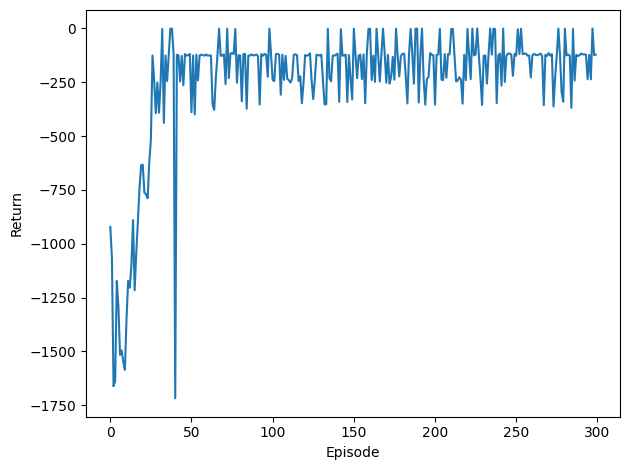

In [2]:
# sac_pendulum.py
# ------------------------------------------------------------
#  Soft Actor–Critic (v2, no separate V-network) for Pendulum-v1
# ------------------------------------------------------------
import math, random, time, collections, os, argparse
from itertools import count
from types import SimpleNamespace   # handy stand-in for argparse.Namespace

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------
#  Hyper-parameters (override from CLI if you like)
# ------------------------------------------------------------
def get_args():
    p = argparse.ArgumentParser()
    p.add_argument("--env",           default="Pendulum-v1")
    p.add_argument("--episodes",      type=int,   default=300)
    p.add_argument("--steps-per-ep",  type=int,   default=200)   # T
    p.add_argument("--batch",         type=int,   default=256)
    p.add_argument("--replay",        type=int,   default=50_000)
    p.add_argument("--start-steps",   type=int,   default=1_000) # random policy steps
    p.add_argument("--updates-per-step", type=int, default=1)
    p.add_argument("--gamma",         type=float, default=0.99)
    p.add_argument("--tau",           type=float, default=0.005) # soft-update rate
    p.add_argument("--lr",            type=float, default=3e-4)
    p.add_argument("--hidden",        type=int,   default=256)
    p.add_argument("--seed",          type=int,   default=0)
    p.add_argument("--target-entropy",type=float, default=None,  # set automatically
                   help="If None, use −|A| by default")
    return p.parse_args()

# ------------------------------------------------------------
#  Replay buffer
# ------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim, device):
        self.device = device
        self.capacity = capacity
        self.ptr = 0
        self.size = 0
        self.obs_buf  = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.act_buf  = torch.zeros((capacity, act_dim),  dtype=torch.float32, device=device)
        self.rew_buf  = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)
        self.next_buf = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.done_buf = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]   = torch.as_tensor(obs,  device=self.device)
        self.act_buf[self.ptr]   = torch.as_tensor(act,  device=self.device)
        self.rew_buf[self.ptr]   = torch.as_tensor([rew],device=self.device)
        self.next_buf[self.ptr]  = torch.as_tensor(next_obs, device=self.device)
        self.done_buf[self.ptr]  = torch.as_tensor([done],device=self.device)

        self.ptr  = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return ( self.obs_buf[idx],
                 self.act_buf[idx],
                 self.rew_buf[idx],
                 self.next_buf[idx],
                 self.done_buf[idx] )

# ------------------------------------------------------------
#  Helper nets
# ------------------------------------------------------------
LOG_STD_MIN, LOG_STD_MAX = -5.0, 2.0

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),  nn.ReLU())
        self.mean  = nn.Linear(hidden, act_dim)
        self.logsd = nn.Linear(hidden, act_dim)
        self.max_action = max_action

    def _dist(self, obs):
        h = self.net(obs)
        mu = self.mean(h)
        log_std = torch.clamp(self.logsd(h), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std, log_std

    def forward(self, obs):
        mu, std, log_std = self._dist(obs)
        eps = torch.randn_like(std)
        pre_tanh = mu + std * eps  # reparameterisation
        action = torch.tanh(pre_tanh)
        logp = (
            -0.5 * ((pre_tanh - mu) / std).pow(2)
            - log_std
            - 0.5 * math.log(2 * math.pi)
        ).sum(-1, keepdim=True)
        # change-of-variables for tanh: see Appendix C in SAC paper
        logp -= torch.log(1 - action.pow(2) + 1e-6).sum(-1, keepdim=True)
        return action * self.max_action, logp  # scaled to env bounds


    def act(self, obs, deterministic=False):
        with torch.no_grad():
            if deterministic:
                mu, _ = self._dist(obs)
                action = torch.tanh(mu) * self.max_action
                return action
            else:
                a, _ = self.forward(obs)
                return a

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden):
        super().__init__()
        self.Q1 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))
        self.Q2 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.Q1(x), self.Q2(x)

# ------------------------------------------------------------
#  SAC Agent
# ------------------------------------------------------------
class SACAgent:
    def __init__(self, obs_dim, act_dim, max_action, args, device):
        self.device = device
        self.actor  = Actor(obs_dim, act_dim, args.hidden, max_action).to(device)
        self.critic = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target.load_state_dict(self.critic.state_dict())

        self.actor_opt  = torch.optim.Adam(self.actor.parameters(),  lr=args.lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=args.lr)

        # entropy temperature
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=device)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=args.lr)
        self.target_entropy = ( -act_dim if args.target_entropy is None
                                else args.target_entropy )

        self.gamma = args.gamma
        self.tau   = args.tau
        self.max_action = max_action

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def update(self, replay, batch_size):
        obs, act, rew, next_obs, done = replay.sample(batch_size)
        # ----- critic -----
        with torch.no_grad():
            next_act, next_logp = self.actor(next_obs)
            tq1, tq2 = self.target(next_obs, next_act)
            tq = torch.min(tq1, tq2) - self.alpha * next_logp
            target_Q = rew + self.gamma * (1 - done) * tq

        cur_q1, cur_q2 = self.critic(obs, act)
        critic_loss = F.mse_loss(cur_q1, target_Q) + F.mse_loss(cur_q2, target_Q)

        self.critic_opt.zero_grad(set_to_none=True)
        critic_loss.backward()
        self.critic_opt.step()

        # ----- actor -----
        new_act, logp = self.actor(obs)
        q1_pi, q2_pi = self.critic(obs, new_act)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * logp - q_pi).mean()

        self.actor_opt.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor_opt.step()

        # ----- temperature -----
        alpha_loss = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(set_to_none=True)
        alpha_loss.backward()
        self.alpha_opt.step()

        # ----- soft update target -----
        with torch.no_grad():
            for p, tp in zip(self.critic.parameters(), self.target.parameters()):
                tp.data.lerp_(p.data, self.tau)

# ------------------------------------------------------------
#  Training loop
# ------------------------------------------------------------
def main():
    # args = get_args()
    args = SimpleNamespace(
        env              = "Pendulum-v1",
        episodes         = 300,
        steps_per_ep     = 200,        # T
        batch            = 256,
        replay           = 50_000,
        start_steps      = 1_000,      # random policy steps
        updates_per_step = 1,
        gamma            = 0.99,
        tau              = 0.005,      # soft-update rate
        lr               = 3e-4,
        hidden           = 256,
        seed             = 0,
        target_entropy   = None,       # if None, = −|A|
    )

    
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make(args.env)
    obs_dim = env.observation_space.shape[0]          # 3
    act_dim = env.action_space.shape[0]               # 1
    max_action = float(env.action_space.high[0])

    replay = ReplayBuffer(args.replay, obs_dim, act_dim, device)
    agent  = SACAgent(obs_dim, act_dim, max_action, args, device)

    episode_returns = []
    global_steps = 0

    for ep in range(1, args.episodes + 1):
        obs, _ = env.reset(seed=args.seed + ep)
        ep_ret, ep_steps = 0.0, 0

        for t in range(args.steps_per_ep):
            # --- act ---
            if global_steps < args.start_steps:
                act = env.action_space.sample()
            else:
                act = agent.actor.act(torch.as_tensor(obs, device=device).unsqueeze(0))
                act = act.squeeze(0).cpu().numpy()

            next_obs, reward, terminated, truncated, _ = env.step(act)
            done = terminated or truncated
            ep_ret += reward

            # store
            replay.add(obs, act, reward, next_obs, float(done))
            obs = next_obs
            ep_steps += 1
            global_steps += 1

            # --- update ---
            if replay.size >= args.batch:
                for _ in range(args.updates_per_step):
                    agent.update(replay, args.batch)

            if done:
                break

        episode_returns.append(ep_ret)
        print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f}")

    env.close()

    # quick-n-dirty plot (optional)
    try:
        import matplotlib.pyplot as plt
        plt.plot(episode_returns)
        plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout()
        plt.show()
    except ModuleNotFoundError:
        pass

main()

## 마지막 실험

In [6]:
# sac_pendulum.py
# ------------------------------------------------------------
#  Soft Actor–Critic (v2, no separate V-network) for Pendulum-v1
# ------------------------------------------------------------
import math, random, time, collections, os, argparse
from itertools import count
from types import SimpleNamespace   # handy stand-in for argparse.Namespace
from time import time

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------
#  Hyper-parameters (override from CLI if you like)
# ------------------------------------------------------------
def get_args():
    p = argparse.ArgumentParser()
    p.add_argument("--env",           default="Pendulum-v1")
    p.add_argument("--episodes",      type=int,   default=300)
    p.add_argument("--steps-per-ep",  type=int,   default=200)   # T
    p.add_argument("--batch",         type=int,   default=256)
    p.add_argument("--replay",        type=int,   default=50_000)
    p.add_argument("--start-steps",   type=int,   default=1_000) # random policy steps
    p.add_argument("--updates-per-step", type=int, default=1)
    p.add_argument("--gamma",         type=float, default=0.99)
    p.add_argument("--tau",           type=float, default=0.005) # soft-update rate
    p.add_argument("--lr",            type=float, default=3e-4)
    p.add_argument("--hidden",        type=int,   default=256)
    p.add_argument("--seed",          type=int,   default=0)
    p.add_argument("--target-entropy",type=float, default=None,  # set automatically
                   help="If None, use −|A| by default")
    return p.parse_args()

# ------------------------------------------------------------
#  Replay buffer
# ------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim, device):
        self.device = device
        self.capacity = capacity
        self.ptr = 0
        self.size = 0
        self.obs_buf  = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.act_buf  = torch.zeros((capacity, act_dim),  dtype=torch.float32, device=device)
        self.rew_buf  = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)
        self.next_buf = torch.zeros((capacity, obs_dim),  dtype=torch.float32, device=device)
        self.done_buf = torch.zeros((capacity, 1),        dtype=torch.float32, device=device)

    def add(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]   = torch.as_tensor(obs,  device=self.device)
        self.act_buf[self.ptr]   = torch.as_tensor(act,  device=self.device)
        self.rew_buf[self.ptr]   = torch.as_tensor([rew],device=self.device)
        self.next_buf[self.ptr]  = torch.as_tensor(next_obs, device=self.device)
        self.done_buf[self.ptr]  = torch.as_tensor([done],device=self.device)

        self.ptr  = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = torch.randint(0, self.size, (batch_size,), device=self.device)
        return ( self.obs_buf[idx],
                 self.act_buf[idx],
                 self.rew_buf[idx],
                 self.next_buf[idx],
                 self.done_buf[idx] )

# ------------------------------------------------------------
#  Helper nets
# ------------------------------------------------------------
LOG_STD_MIN, LOG_STD_MAX = -5.0, 2.0

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),  nn.ReLU())
        self.mean  = nn.Linear(hidden, act_dim)
        self.logsd = nn.Linear(hidden, act_dim)
        self.max_action = max_action

    def _dist(self, obs):
        h = self.net(obs)
        mu = self.mean(h)
        log_std = torch.clamp(self.logsd(h), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std, log_std

    def forward(self, obs):
        mu, std, log_std = self._dist(obs)
        eps = torch.randn_like(std)
        pre_tanh = mu + std * eps  # reparameterisation
        action = torch.tanh(pre_tanh)
        logp = (
            -0.5 * ((pre_tanh - mu) / std).pow(2)
            - log_std
            - 0.5 * math.log(2 * math.pi)
        ).sum(-1, keepdim=True)
        # change-of-variables for tanh: see Appendix C in SAC paper
        logp -= torch.log(1 - action.pow(2) + 1e-6).sum(-1, keepdim=True)
        return action * self.max_action, logp  # scaled to env bounds


    def act(self, obs, deterministic=False):
        with torch.no_grad():
            if deterministic:
                mu, _ = self._dist(obs)
                action = torch.tanh(mu) * self.max_action
                return action
            else:
                a, _ = self.forward(obs)
                return a

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden):
        super().__init__()
        self.Q1 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))
        self.Q2 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1))

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.Q1(x), self.Q2(x)

# ------------------------------------------------------------
#  SAC Agent
# ------------------------------------------------------------
class SACAgent:
    def __init__(self, obs_dim, act_dim, max_action, args, device):
        self.device = device
        self.actor  = Actor(obs_dim, act_dim, args.hidden, max_action).to(device)
        self.critic = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target = Critic(obs_dim, act_dim, args.hidden).to(device)
        self.target.load_state_dict(self.critic.state_dict())

        self.actor_opt  = torch.optim.Adam(self.actor.parameters(),  lr=args.lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=args.lr)

        # entropy temperature
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=device)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=args.lr)
        self.target_entropy = ( -act_dim if args.target_entropy is None
                                else args.target_entropy )

        self.gamma = args.gamma
        self.tau   = args.tau
        self.max_action = max_action

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def update(self, replay, batch_size):
        obs, act, rew, next_obs, done = replay.sample(batch_size)
        # ----- critic -----
        with torch.no_grad():
            next_act, next_logp = self.actor(next_obs)
            tq1, tq2 = self.target(next_obs, next_act)
            tq = torch.min(tq1, tq2) - self.alpha * next_logp
            target_Q = rew + self.gamma * (1 - done) * tq

        cur_q1, cur_q2 = self.critic(obs, act)
        critic_loss = F.mse_loss(cur_q1, target_Q) + F.mse_loss(cur_q2, target_Q)

        self.critic_opt.zero_grad(set_to_none=True)
        critic_loss.backward()
        self.critic_opt.step()

        # ----- actor -----
        new_act, logp = self.actor(obs)
        q1_pi, q2_pi = self.critic(obs, new_act)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * logp - q_pi).mean()

        self.actor_opt.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor_opt.step()

        # ----- temperature -----
        alpha_loss = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(set_to_none=True)
        alpha_loss.backward()
        self.alpha_opt.step()

        # ----- soft update target -----
        with torch.no_grad():
            for p, tp in zip(self.critic.parameters(), self.target.parameters()):
                tp.data.lerp_(p.data, self.tau)

# ------------------------------------------------------------
#  Training loop
# ------------------------------------------------------------
# args = get_args()
env_name = "Pendulum-v1"

env = gym.make(env_name)

args = SimpleNamespace(
    env              = env_name,
    episodes         = 300,
    steps_per_ep     = 200,        # T
    batch            = 256,
    replay           = 50_000,
    start_steps      = 1_000,      # random policy steps
    updates_per_step = 1,
    exponent  = 0.5,
    gamma     = math.exp(- 0.5 * env.unwrapped.dt),
    sigma = 0.05,
    tau              = env.unwrapped.dt,      # soft-update rate
    dt              = env.unwrapped.dt,
    lr               = 3e-4,
    hidden           = 256,
    seed             = 0,
    target_entropy   = None,       # if None, = −|A|
)
    

torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

obs_dim = env.observation_space.shape[0]          # 3
act_dim = env.action_space.shape[0]               # 1
max_action = float(env.action_space.high[0])

replay = ReplayBuffer(args.replay, obs_dim, act_dim, device)
agent  = SACAgent(obs_dim, act_dim, max_action, args, device)

episode_returns = []
global_steps = 0

start = time()
for ep in range(1, args.episodes + 1):
    obs, _ = env.reset(seed=args.seed + ep)
    ep_ret, ep_steps = 0.0, 0

    for t in range(args.steps_per_ep):
        # --- act ---
        if global_steps < args.start_steps:
            act = env.action_space.sample()
        else:
            act = agent.actor.act(torch.as_tensor(obs, device=device).unsqueeze(0))
            act = act.squeeze(0).cpu().numpy()

        next_obs, reward, terminated, truncated, _ = env.step(act)
        next_state = env.unwrapped.state
        done = terminated or truncated

        # --- add stochastic diffusion ---
        #  convert to torch on the right device
        st = torch.as_tensor(next_state, dtype=torch.float32, device=device)
        
        # ΔW ~ N(0, dt * I)
        dW = torch.randn_like(st) * math.sqrt(args.dt)
        
        # element-wise form:  x_next = x_env + σ(x,a) ∘ ΔW
        # st_noisy = st + sigma(st, action) * dW
        st_noisy = st + args.sigma * dW
        
        # back to NumPy for the replay buffer
        next_state = st_noisy.cpu().numpy()
        env.unwrapped.state = st_noisy.cpu().numpy().copy()
        
        ep_ret += reward * (args.gamma ** t)

        # store
        replay.add(obs, act, reward, next_obs, float(done))
        obs = next_obs
        ep_steps += 1
        global_steps += 1

        # --- update ---
        if replay.size >= args.batch:
            for _ in range(args.updates_per_step):
                agent.update(replay, args.batch)

        if done:
            break

    episode_returns.append(ep_ret)
    elapsed_time = time() - start
    print(f"Ep {ep:4d} | return {ep_ret:8.1f} | α {agent.alpha.item():.3f}")
    print(f"elapsed time: {elapsed_time}")


env.close()

# quick-n-dirty plot (optional)
try:
    import matplotlib.pyplot as plt
    plt.plot(episode_returns)
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout()
    plt.show()
except ModuleNotFoundError:
    pass

Ep    1 | return   -166.7 | α 1.000
elapsed time: 0.1906113624572754
Ep    2 | return   -236.4 | α 0.959
elapsed time: 1.8724474906921387
Ep    3 | return   -331.6 | α 0.912
elapsed time: 4.054149627685547
Ep    4 | return   -333.0 | α 0.863
elapsed time: 6.317927360534668
Ep    5 | return   -281.3 | α 0.817
elapsed time: 9.235435485839844
Ep    6 | return   -164.3 | α 0.767
elapsed time: 11.883252620697021
Ep    7 | return   -190.3 | α 0.723
elapsed time: 14.657362222671509
Ep    8 | return   -182.8 | α 0.684
elapsed time: 17.23791527748108
Ep    9 | return   -258.8 | α 0.647
elapsed time: 19.780808448791504
Ep   10 | return   -346.2 | α 0.613
elapsed time: 21.99785804748535
Ep   11 | return   -248.9 | α 0.585
elapsed time: 24.878172636032104
Ep   12 | return   -194.5 | α 0.561
elapsed time: 27.691412210464478
Ep   13 | return   -236.2 | α 0.536
elapsed time: 30.24315881729126
Ep   14 | return   -226.2 | α 0.511
elapsed time: 32.771071434020996
Ep   15 | return   -195.1 | α 0.485
elap

KeyboardInterrupt: 

In [7]:
import os
results_dir = "results/ms/sac/pendulum"
os.makedirs(results_dir, exist_ok=True)

# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(episode_returns))
print(f"Reward history saved to {reward_file}")

Reward history saved to results/ms/sac/pendulum/reward_history.npy


## old

In [14]:
# ------------------------------------------------------------
#  helper: fetch env time-step (≈ 0.02 s for CartPole, etc.)
# ------------------------------------------------------------
def _default_dt(env, fallback=0.02):
    return getattr(env.unwrapped, "tau", fallback)

# ------------------------------------------------------------
#  evaluation
# ------------------------------------------------------------
@torch.no_grad()
def evaluate_policy(
    policy_net,
    args,
    env,
    sigma,                       # your diffusion coefficient  σ(x,a)
    x_norm_hist_hist,            # (N_eval, T)  – pre-allocated outside
    u_norm_hist_hist,            # (N_eval, T)
):
    """
    Runs `eval_num_traj` roll-outs of length `eval_traj_len` **sequentially**
    (because `env` is not vectorised).

    After the call:
        x_norm_hist_hist[i]  ← ‖x_t‖ history for trajectory *i*
        u_norm_hist_hist[i]  ← ‖u_t‖ history for trajectory *i*
    and the function returns mean quantities that your training loop
    can log or plot.

    NOTE: the function does *not* re-allocate those tensors – it *fills*
    the ones you pass in, keeping memory usage predictable.
    """
    policy_net.eval()
    dt = _default_dt(env)                      # physics Δt for Brownian step

    # per-trajectory accumulators
    episode_returns = torch.zeros(args.eval_num_traj, device=args.device)

    steps = []
    for traj_idx in range(args.eval_num_traj):

        # ------------------------------------------------------------------
        #  (1) reset env  ➜  initial state   x₀
        # ------------------------------------------------------------------
        obs, _ = env.reset()
        x_t = torch.as_tensor(obs, dtype=torch.float32, device=args.device)

        step = 0
        for t in range(args.eval_traj_len):
            step += 1
            # --------------------------------------------------------------
            #  (2) policy   u_t = π(x_t)
            # --------------------------------------------------------------
            u_t = policy_net(x_t.unsqueeze(0)).squeeze(0)      # (d_u,)
            u_norm_hist_hist[traj_idx, t] = torch.norm(u_t)     # log ‖u_t‖

            # ε-greedy / deterministic argmax – change if you sample actions
            action = int(u_t.argmax().item())

            # --------------------------------------------------------------
            #  (3) env step – deterministic part
            # --------------------------------------------------------------
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_returns[traj_idx] += reward * (args.gamma ** t)

            # --------------------------------------------------------------
            #  (4) add process noise  x_{t+1} ← x_env + σ ΔW
            # --------------------------------------------------------------
            st = torch.as_tensor(next_state, dtype=torch.float32,
                                 device=args.device)
            dW = torch.randn_like(st) * math.sqrt(dt)
            st_noisy = st + sigma * dW

            # overwrite env’s internal physics state so the *next* step
            # integrates from the noisy version
            env.unwrapped.state = st_noisy.cpu().numpy().copy()

            # log ‖x_t‖ **after** noise (matches state fed back to agent)
            x_norm_hist_hist[traj_idx, t] = torch.norm(st_noisy)

            # prepare for next loop
            x_t = st_noisy

            if terminated or truncated:
                # pad the rest of the trajectory with the last norm value
                # so the history tensor keeps shape (T,) for every rollout
                if t + 1 < args.eval_traj_len:
                    x_norm_hist_hist[traj_idx, t + 1 :] = x_norm_hist_hist[traj_idx, t]
                    u_norm_hist_hist[traj_idx, t + 1 :] = 0.0
                break
        steps.append(step)
        
    # ----------------------------------------------------------------------
    #  aggregate across trajectories  (mean curve + scalar mean return)
    # ----------------------------------------------------------------------
    mean_step = np.array(steps).mean()
    mean_return   = episode_returns.mean()
    mean_x_norm   = x_norm_hist_hist.mean(dim=0)   # (T,)
    mean_u_norm   = u_norm_hist_hist.mean(dim=0)   # (T,)

    policy_net.train()
    return mean_return, mean_x_norm, mean_u_norm, mean_step


env_id        = "Pendulum-v1"
env = gym.make(env_id)
nS, nA = env.observation_space.shape[0], env.action_space.n


# ---------- 1. Hyper-params ----------
class Args:
    env_id        = "Pendulum-v1"
    eps_start     = 1.0
    eps_end       = 0.05
    eps_decay     = 10_000          # linear decay over N steps
    lr            = 1e-3
    tau           = env.unwrapped.tau   # 0.005           # soft-update factor
    exponent      = 0.5
    gamma         = math.exp(- 0.5 * env.unwrapped.tau)
    hidden        = 128
    replay_size   = 50_000
    batch_size    = 128
    min_buffer    = 1_000
    episodes      = 100  # 200
    target_update = 10              # hard-sync every N episodes (extra safety)
    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    eval_traj_len = 500
    eval_num_traj = 10
    d_x           = 4
    d_u           = 1
    sigma         = 0.1
    
args = Args()

# ---------- 2. Utils ----------
Transition = namedtuple("Transition",
                        ("state", "action", "reward", "next_state", "done"))

class ReplayBuffer:
    def __init__(self, cap):
        self.buffer = deque(maxlen=cap)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, n, device):
        batch = random.sample(self.buffer, n)
        trans = Transition(*zip(*batch))
        to_t = lambda x: torch.as_tensor(x, device=device, dtype=torch.float32)
        return tuple(map(to_t, trans))

    def __len__(self): return len(self.buffer)

# ---------- 3. Q-network ----------
def mlp(in_dim, out_dim, hidden):
    return nn.Sequential(
        nn.Linear(in_dim, hidden), nn.ReLU(),
        nn.Linear(hidden, hidden), nn.ReLU(),
        nn.Linear(hidden, out_dim)
    )

policy_net  = mlp(nS, nA, args.hidden).to(args.device)
target_net  = mlp(nS, nA, args.hidden).to(args.device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optim = torch.optim.Adam(policy_net.parameters(), lr=args.lr)
memory = ReplayBuffer(args.replay_size)

# epsilon scheduler
def epsilon_by_step(step):
    frac = max(0, min(1, step / args.eps_decay))
    return args.eps_start - frac * (args.eps_start - args.eps_end)

# ---------- 4. Training loop ----------
reward_history = []
global_step = 0
dt = env.unwrapped.tau if hasattr(env.unwrapped, "tau") else 0.02  # CartPole ≈ 0.02 s
x_norm_hist_hist = torch.zeros(
    args.episodes, args.eval_traj_len, device=args.device
)
u_norm_hist_hist = torch.zeros(
    args.episodes, args.eval_traj_len, device=args.device
)
steps_hist = []
start = time()
elapsed_times = []
for ep in trange(args.episodes, desc="Episodes"):
    state, _ = env.reset()
    ep_return = 0
    for t in count():
        eps = epsilon_by_step(global_step)
        global_step += 1

        # ε-greedy action
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q = policy_net(torch.as_tensor(state, device=args.device))
                action = int(q.argmax())

        next_state, reward, terminated, truncated, _ = env.step(action)


        # --- add stochastic diffusion ---
        #  convert to torch on the right device
        st = torch.as_tensor(next_state, dtype=torch.float32, device=args.device)
        
        # ΔW ~ N(0, dt * I)
        dW = torch.randn_like(st) * math.sqrt(dt)
        
        # element-wise form:  x_next = x_env + σ(x,a) ∘ ΔW
        # st_noisy = st + sigma(st, action) * dW
        st_noisy = st + args.sigma * dW
        
        # back to NumPy for the replay buffer
        next_state = st_noisy.cpu().numpy()
        env.unwrapped.state = st_noisy.cpu().numpy().copy()

        
        # --- store transition ---        
        done = terminated or truncated
        memory.push(state, action, reward, next_state, done)
        state = next_state
        ep_return += reward

        # ----- gradient step -----
        if len(memory) >= args.min_buffer:
            s, a, r, ns, d = memory.sample(args.batch_size, args.device)

            q_sa   = policy_net(s).gather(1, a.long().unsqueeze(1)).squeeze()
            with torch.no_grad():
                q_next = target_net(ns).max(1).values
                target = r + args.gamma * (1 - d) * q_next

            loss = F.mse_loss(q_sa, target)

            optim.zero_grad()
            loss.backward()
            optim.step()

            # soft update
            for p, tp in zip(policy_net.parameters(), target_net.parameters()):
                tp.data.lerp_(p.data, args.tau)

        if done: break

    avg_reward, x_norm_hist, u_norm_hist, mean_step = evaluate_policy(policy_net, args, env, args.sigma, x_norm_hist_hist, u_norm_hist_hist)  # returns.append(ep_return)
    avg_reward = avg_reward.item()
    steps_hist.append(mean_step)
    reward_history.append(avg_reward)
    x_norm_hist_hist[ep, :] = x_norm_hist
    u_norm_hist_hist[ep, :] = u_norm_hist
    # optional hard update every N episodes
    if ep % args.target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    elapsed_times.append(time() - start)

env.close()

results_dir = os.path.join("results/ms/pendulum/sac")
os.makedirs(results_dir, exist_ok=True)
reward_file_path = save_reward_history(reward_history, results_dir)
save_model(target_net, policy_net, results_dir)
elapsed_path = save_elapsed_times(elapsed_times, results_dir)
plot_reward_history(reward_file_path, results_dir)
plot_reward_history(reward_file_path, results_dir, elapsed_path=elapsed_path)
plot_x_norm_trajectory(
    x_norm_hist_hist, args.eval_traj_len, args.episodes, results_dir
)
plot_u_norm_trajectory(
    u_norm_hist_hist, args.eval_traj_len, args.episodes, results_dir
)
plot_avg_steps(range(1, args.episodes + 1), steps_hist, results_dir)

# ---------- 5. Plot results ----------
plt.figure(figsize=(7,4))
plt.plot(reward_history, label="Episode return")
plt.axhline(475, ls="--", c="k", alpha=0.5, label="Solving threshold")
# running mean for smoother curve
mean100 = np.convolve(reward_history, np.ones(100)/100, mode="valid")
plt.plot(range(99, len(reward_history)), mean100, lw=2, label="100-ep mean")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.tight_layout()
plt.show()

AttributeError: 'Box' object has no attribute 'n'

## chatgpt

In [13]:
# sac_pendulum.py
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from collections import deque
import random, math, time, os

# ──────────────────────────────────────────────────────────────
#  Hyper-parameters
# ──────────────────────────────────────────────────────────────
ENV_NAME          = "Pendulum-v1"
TOTAL_STEPS       = 10000          # ≈ 300 episodes
START_STEPS       = 5_000            # collect with random policy
UPDATE_AFTER      = 1_000            # begin gradient updates
UPDATE_EVERY      = 50               # update frequency (env steps)
GRAD_STEPS        = 50               # SGD steps per update
BATCH_SIZE        = 256
REPLAY_CAPACITY   = int(1e6)
GAMMA             = 0.99
TAU               = 0.005            # target-net Polyak factor
POLICY_LR         = 3e-4
Q_LR              = 3e-4
ALPHA_LR          = 3e-4
HIDDEN            = 256
SEED              = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.autograd.set_detect_anomaly(True)


# ──────────────────────────────────────────────────────────────
#  Helpers
# ──────────────────────────────────────────────────────────────
def mlp(in_dim, out_dim, hidden=HIDDEN, act=nn.SiLU):
    return nn.Sequential(
        nn.Linear(in_dim, hidden), act(),
        nn.Linear(hidden, hidden), act(),
        nn.Linear(hidden, out_dim)
    )

class ReplayBuffer:
    def __init__(self, capacity):
        self.store = deque(maxlen=capacity)
    def push(self, *transition):
        self.store.append(tuple(map(np.asarray, transition)))
    def sample(self, batch):
        batch = random.sample(self.store, batch)
        s, a, r, s2, d = map(np.stack, zip(*batch))
        return (
            torch.as_tensor(s,  dtype=torch.float32, device=device),
            torch.as_tensor(a,  dtype=torch.float32, device=device),
            torch.as_tensor(r,  dtype=torch.float32, device=device).unsqueeze(1),
            torch.as_tensor(s2, dtype=torch.float32, device=device),
            torch.as_tensor(d,  dtype=torch.float32, device=device).unsqueeze(1)
        )
    def __len__(self): return len(self.store)

# ──────────────────────────────────────────────────────────────
#  Networks
# ──────────────────────────────────────────────────────────────
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, max_torque):
        super().__init__()
        self.mu_logstd = mlp(obs_dim, 2*act_dim)
        self.max_torque = max_torque
    def forward(self, s):
        mu, log_std = self.mu_logstd(s).chunk(2, dim=-1)
        log_std = torch.clamp(log_std, -20, 2)          # practical bounds
        std     = torch.exp(log_std)
        dist    = torch.distributions.Normal(mu, std)
        x_t     = dist.rsample()                        # re-parameterised sample
        a_pre   = torch.tanh(x_t)
        a       = a_pre * self.max_torque
        # log-prob with tanh-squash correction
        logp = dist.log_prob(x_t) - torch.log(
            self.max_torque * (1 - a_pre.pow(2)) + 1e-6
        )
        return a, logp.sum(dim=-1, keepdim=True)

class QNet(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.q = mlp(obs_dim + act_dim, 1)
    def forward(self, s, a):
        return self.q(torch.cat([s, a], dim=-1))

# ──────────────────────────────────────────────────────────────
#  SAC agent
# ──────────────────────────────────────────────────────────────
class SAC:
    def __init__(self, obs_dim, act_dim, max_torque):
        self.actor = Actor(obs_dim, act_dim, max_torque).to(device)
        self.q1    = QNet(obs_dim, act_dim).to(device)
        self.q2    = QNet(obs_dim, act_dim).to(device)
        self.q1_t  = QNet(obs_dim, act_dim).to(device)
        self.q2_t  = QNet(obs_dim, act_dim).to(device)
        self.q1_t.load_state_dict(self.q1.state_dict())
        self.q2_t.load_state_dict(self.q2.state_dict())

        # adaptive temperature α
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.target_entropy = -act_dim   # heuristic
        self.pi_opt = optim.Adam(self.actor.parameters(), lr=POLICY_LR)
        self.q_opt  = optim.Adam(
            list(self.q1.parameters()) + list(self.q2.parameters()), lr=Q_LR
        )
        self.a_opt  = optim.Adam([self.log_alpha], lr=ALPHA_LR)

    @property
    def alpha(self): return self.log_alpha.exp()

    @torch.no_grad()
    def act(self, s, deterministic=False):
        s = torch.as_tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
        a, logp = self.actor(s)
        if deterministic: a = torch.tanh(self.actor.mu_logstd(s)[0,:1])*self.actor.max_torque
        return a.squeeze(0).cpu().numpy()

    def update(self, replay):
        for _ in range(GRAD_STEPS):
            s, a, r, s2, done = replay.sample(BATCH_SIZE)
    
            # ───── 1. Critic update ──────────────────────────────────────────
            with torch.no_grad():
                a2, logp2 = self.actor(s2)
                q_min_t   = torch.minimum(
                    self.q1_t(s2, a2), self.q2_t(s2, a2)
                ) - self.alpha * logp2
                y = r + GAMMA * (1 - done) * q_min_t
    
            q1, q2   = self.q1(s, a), self.q2(s, a)
            q_loss   = ((q1 - y).pow(2) + (q2 - y).pow(2)).mean()
    
            self.q_opt.zero_grad()
            q_loss.backward()
            self.q_opt.step()
    
            # ───── 2. Actor (policy) update  ────────────────────────────────
            # freeze critics to save mem – no grad needed for them now
            for p in self.q1.parameters(): p.requires_grad_(False)
            for p in self.q2.parameters(): p.requires_grad_(False)
    
            a_pi, logp_pi = self.actor(s)
            q_pi = torch.minimum(self.q1(s, a_pi), self.q2(s, a_pi))
            pi_loss = (self.alpha.detach() * logp_pi - q_pi).mean()
    
            self.pi_opt.zero_grad()
            pi_loss.backward()
            self.pi_opt.step()
    
            # un-freeze critics
            for p in self.q1.parameters(): p.requires_grad_(True)
            for p in self.q2.parameters(): p.requires_grad_(True)
    
            # ───── 3. Temperature α update  ─────────────────────────────────
            alpha_loss = (
                -(self.log_alpha) * (logp_pi.detach() + self.target_entropy)
            ).mean()
    
            self.a_opt.zero_grad()
            alpha_loss.backward()
            self.a_opt.step()
    
            # ───── 4. Soft-update target critics ────────────────────────────
            with torch.no_grad():
                for p, p_t in zip(self.q1.parameters(), self.q1_t.parameters()):
                    p_t.mul_(1 - TAU).add_(TAU * p)
                for p, p_t in zip(self.q2.parameters(), self.q2_t.parameters()):
                    p_t.mul_(1 - TAU).add_(TAU * p)

    
    # def update(self, replay):
    #     for _ in range(GRAD_STEPS):
    #         s, a, r, s2, done = replay.sample(BATCH_SIZE)

    #         # --- value targets -------------------------------------------
    #         with torch.no_grad():
    #             a2, logp2 = self.actor(s2)
    #             q1_t = self.q1_t(s2, a2)
    #             q2_t = self.q2_t(s2, a2)
    #             q_min = torch.minimum(q1_t, q2_t) - self.alpha * logp2
    #             y = r + GAMMA * (1 - done) * q_min

    #         # --- Q loss ---------------------------------------------------
    #         q1, q2 = self.q1(s, a), self.q2(s, a)
    #         q_loss = ((q1 - y).pow(2) + (q2 - y).pow(2)).mean()

    #         # --- Policy loss ---------------------------------------------
    #         a_pi, logp_pi = self.actor(s)
    #         q1_pi = self.q1(s, a_pi)
    #         q2_pi = self.q2(s, a_pi)
    #         q_pi  = torch.minimum(q1_pi, q2_pi)
    #         # pi_loss = (self.alpha * logp_pi - q_pi).mean()
    #         pi_loss = (self.alpha.detach() * logp_pi - q_pi).mean()   # α NOT detached from grads


    #         # --- α loss ---------------------------------------------------
    #         # alpha_loss = (-self.log_alpha * (logp_pi + self.target_entropy).detach()).mean()
    #         alpha_loss = (-(self.log_alpha) * (logp_pi.detach() + self.target_entropy)).mean()

            
    #         # --- Gradient steps ------------------------------------------
    #         self.q_opt.zero_grad();    q_loss.backward();     self.q_opt.step()
    #         self.pi_opt.zero_grad();   pi_loss.backward();    self.pi_opt.step()
    #         self.a_opt.zero_grad();    alpha_loss.backward(); self.a_opt.step()

    #         # --- Soft-update targets -------------------------------------
    #         with torch.no_grad():
    #             for p, p_t in zip(self.q1.parameters(), self.q1_t.parameters()):
    #                 p_t.data.mul_(1-TAU).add_(TAU * p.data)
    #             for p, p_t in zip(self.q2.parameters(), self.q2_t.parameters()):
    #                 p_t.data.mul_(1-TAU).add_(TAU * p.data)
# ──────────────────────────────────────────────────────────────
#  Environment & training loop
# ──────────────────────────────────────────────────────────────
env = gym.make(ENV_NAME)
max_torque = env.unwrapped.max_torque
obs_dim    = env.observation_space.shape[0]   # 3 for Pendulum-v1
act_dim    = env.action_space.shape[0]        # 1

agent  = SAC(obs_dim, act_dim, max_torque)
replay = ReplayBuffer(REPLAY_CAPACITY)

start_time = time.time()
s, _ = env.reset(seed=SEED)
episode_return, episode_len = 0, 0
returns = []

for step in range(1, TOTAL_STEPS + 1):
    # --- select action ---------------------------------------------------
    if step < START_STEPS:
        a = env.action_space.sample()
    else:
        a = agent.act(s)

    # --- env step --------------------------------------------------------
    s2, r, term, trunc, _ = env.step(a)
    done = term or trunc
    replay.push(s, a, r, s2, done)
    s = s2; episode_return += r; episode_len += 1

    # --- episode end -----------------------------------------------------
    if done:
        returns.append(episode_return)
        s, _ = env.reset()
        episode_return, episode_len = 0, 0

    # --- learning --------------------------------------------------------
    if step >= UPDATE_AFTER and step % UPDATE_EVERY == 0:
        agent.update(replay)

    # --- simple log every 5 k steps -------------------------------------
    if step % 100 == 0:
        avg = np.mean(returns[-10:]) if returns else 0.0
        print(f"Step {step:7d} | avg return (last 10): {avg:8.2f} | "
              f"buffer {len(replay):6d} | α {agent.alpha.item():.3f}")

print(f"Training finished in {(time.time()-start_time)/60:.1f} min.")
env.close()

# ──────────────────────────────────────────────────────────────
#  Record a demonstration video
# ──────────────────────────────────────────────────────────────
# vid_env = RecordVideo(
#     gym.make(ENV_NAME, render_mode="rgb_array"),
#     video_folder="videos/",
#     name_prefix="sac_pendulum"
# )
# s, _ = vid_env.reset(seed=SEED)
# for t in range(200):                # 200 frames ~ 8 s
#     a = agent.act(s, deterministic=True)
#     s, r, term, trunc, _ = vid_env.step(a)
#     if term or trunc: break
# vid_env.close()
# print("Video saved to 'videos/'.")


Step     100 | avg return (last 10):     0.00 | buffer    100 | α 1.000
Step     200 | avg return (last 10):  -787.58 | buffer    200 | α 1.000
Step     300 | avg return (last 10):  -787.58 | buffer    300 | α 1.000
Step     400 | avg return (last 10): -1278.16 | buffer    400 | α 1.000
Step     500 | avg return (last 10): -1278.16 | buffer    500 | α 1.000
Step     600 | avg return (last 10): -1245.47 | buffer    600 | α 1.000
Step     700 | avg return (last 10): -1245.47 | buffer    700 | α 1.000
Step     800 | avg return (last 10): -1152.02 | buffer    800 | α 1.000
Step     900 | avg return (last 10): -1152.02 | buffer    900 | α 1.000
Step    1000 | avg return (last 10): -1115.65 | buffer   1000 | α 0.985
Step    1100 | avg return (last 10): -1115.65 | buffer   1100 | α 0.956
Step    1200 | avg return (last 10): -1147.33 | buffer   1200 | α 0.928
Step    1300 | avg return (last 10): -1147.33 | buffer   1300 | α 0.900
Step    1400 | avg return (last 10): -1153.32 | buffer   1400 | 

KeyboardInterrupt: 

# old

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import torch
import numpy as np
from os import path
import math
from typing import Optional, Union

import numpy as np
import torch  # Added for PyTorch tensor operations

import gymnasium as gym
from gymnasium import logger, spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled
from gymnasium.wrappers import RecordVideo


"""
SAC on InvertedPendulum-v4  –  noise-augmented, evaluation-ready.
-----------------------------------------------------------------
python inverted_pendulum_sac.py
"""
import math, os, random, numpy as np
import gymnasium as gym
import torch, torch.nn as nn, torch.nn.functional as F
from collections import deque, namedtuple
from itertools import count
import matplotlib.pyplot as plt
from tqdm import trange

# ------------------------------------------------------------
#  helper I/O (your own util module)
# ------------------------------------------------------------
from lqr.util import (save_reward_history, plot_reward_history,
                      save_model, plot_x_norm_trajectory,
                      plot_u_norm_trajectory, save_elapsed_times, plot_avg_steps)


/tmp/ipykernel_413384/2808851583.py:166: RuntimeWarning: Mean of empty slice.
  mean_steps.append(np.array(steps).mean())



Episode    0 | mean return     5.22

Episode    1 | mean return     4.85

Episode    2 | mean return     5.66

Episode    3 | mean return     5.38

Episode    4 | mean return     4.91

Episode    5 | mean return     5.87

Episode    6 | mean return     5.15

Episode    7 | mean return     4.64

Episode    8 | mean return     5.25

Episode    9 | mean return     5.59

Episode   10 | mean return     5.11

Episode   11 | mean return     5.81

Episode   12 | mean return     5.06

Episode   13 | mean return     4.96

Episode   14 | mean return     5.07

Episode   15 | mean return     4.94

Episode   16 | mean return     5.33

Episode   17 | mean return     5.44

Episode   18 | mean return     5.38

Episode   19 | mean return     5.72

Episode   20 | mean return     4.76

Episode   21 | mean return     5.98

Episode   22 | mean return     5.15

Episode   23 | mean return     5.10

Episode   24 | mean return     5.23

Episode   25 | mean return     5.53

Episode   26 | mean return     6.00



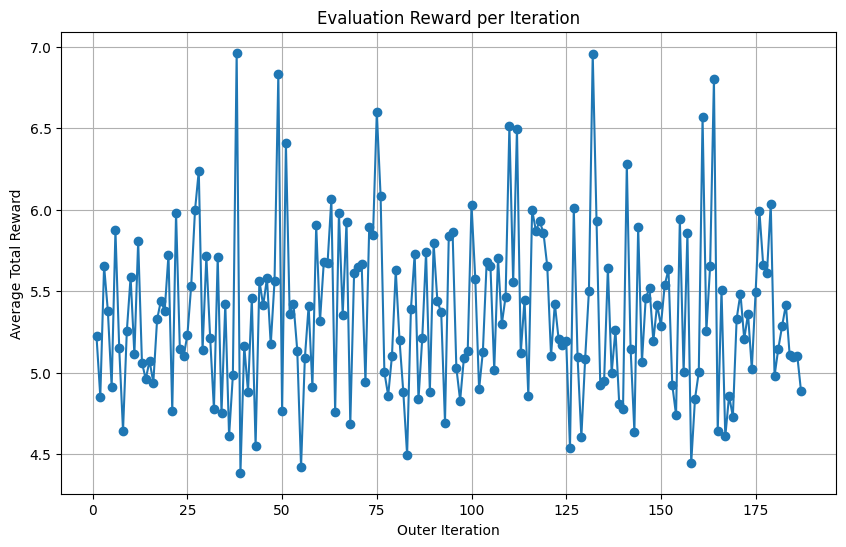

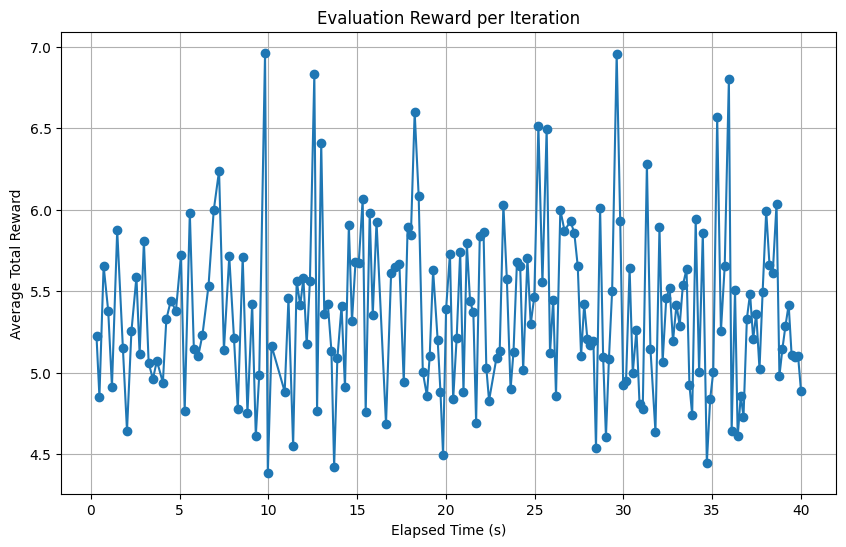

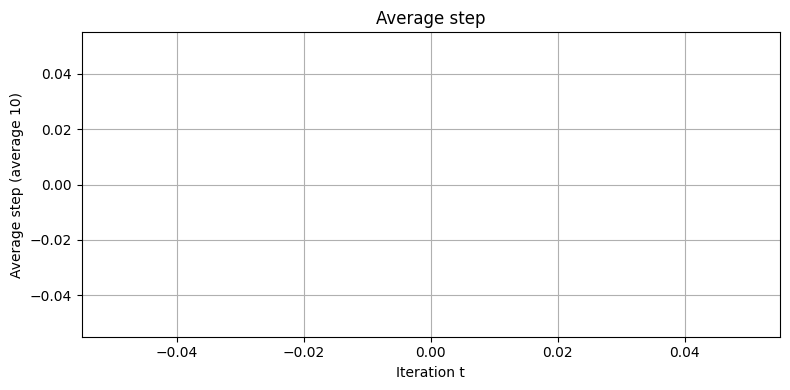

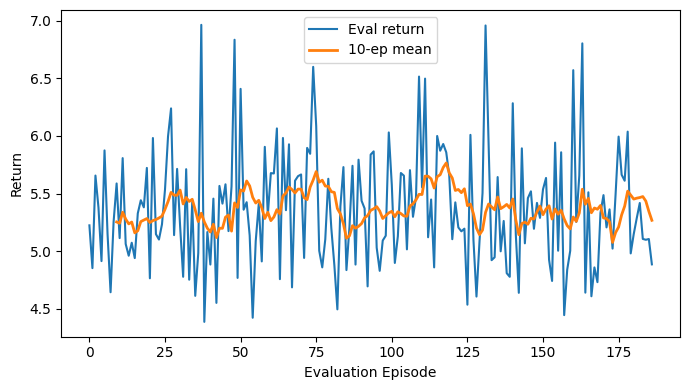

In [7]:

# ------------------------------------------------------------
# 2.  Diffusion coefficient  σ(x,a)  (process noise)
# ------------------------------------------------------------
def sigma(x: torch.Tensor, a) -> torch.Tensor:
    base = 0.02
    return torch.full_like(x, base)

# ------------------------------------------------------------
# 3.  Replay buffer
# ------------------------------------------------------------
Transition = namedtuple("Transition",
                        ("state", "action", "reward", "next_state", "done"))



env_id           = "InvertedPendulum-v4"
# ------------------------------------------------------------
# 5.  Environment
# ------------------------------------------------------------
env = gym.make(env_id)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = float(env.action_space.high[0])
dt = getattr(env.unwrapped, "dt", 0.02)         # MuJoCo envs expose .dt

# ------------------------------------------------------------
# 1.  Hyper-parameters
# ------------------------------------------------------------
class Args:
    env_id           = "InvertedPendulum-v4"
    total_steps      = 200
    batch_size       = 256
    start_steps      = 10_000
    update_every     = 1
    policy_delay     = 1
    hidden           = 256
    lr               = 3e-4
    exponent  = 0.5
    gamma     = math.exp(- 0.5 * dt)
    sigma = 0.05
    tau              = dt          # target-network Polyak factor
    replay_size      = 1_000_000
    target_update_ep = 1              # not used in SAC but kept for parity
    eval_traj_len    = 200
    eval_num_traj    = 30
    device           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()


class ReplayBuffer:
    def __init__(self, cap):
        self.buf = deque(maxlen=cap)

    def push(self, *args):
        self.buf.append(Transition(*args))

    def sample(self, n, device):
        batch = random.sample(self.buf, n)
        trans = Transition(*zip(*batch))
        to_t = lambda x: torch.as_tensor(x, device=device, dtype=torch.float32)
        return tuple(map(to_t, trans))

    def __len__(self): return len(self.buf)

# ------------------------------------------------------------
# 4.  Networks (SAC)
# ------------------------------------------------------------
def mlp(in_dim, out_dim, hidden=args.hidden, depth=2):
    layers = [nn.Linear(in_dim, hidden), nn.ReLU()]
    for _ in range(depth - 1):
        layers += [nn.Linear(hidden, hidden), nn.ReLU()]
    layers.append(nn.Linear(hidden, out_dim))
    return nn.Sequential(*layers)

LOG_STD_MIN, LOG_STD_MAX = -20, 2

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, act_limit):
        super().__init__()
        self.net = mlp(obs_dim, 2 * act_dim)
        self.act_limit = act_limit

    def forward(self, obs):
        mu_logstd = self.net(obs)
        mu, log_std = torch.chunk(mu_logstd, 2, dim=-1)
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, obs):
        mu, std = self(obs)
        dist = torch.distributions.Normal(mu, std)
        raw = dist.rsample()
        logp = dist.log_prob(raw).sum(-1)
        squashed = torch.tanh(raw)
        # log-det Jacobian for tanh
        logp -= torch.log(torch.clip(1.0 - squashed.pow(2), 1e-6, 1.0)
                          ).sum(-1)
        return self.act_limit * squashed, logp

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.Q1 = mlp(obs_dim + act_dim, 1)
        self.Q2 = mlp(obs_dim + act_dim, 1)

    def forward(self, obs, act):
        xu = torch.cat([obs, act], dim=-1)
        return self.Q1(xu).squeeze(-1), self.Q2(xu).squeeze(-1)

# ------------------------------------------------------------
# 6.  Initialise SAC pieces
# ------------------------------------------------------------
actor = Actor(obs_dim, act_dim, act_limit).to(args.device)
critic = Critic(obs_dim, act_dim).to(args.device)
target_critic = Critic(obs_dim, act_dim).to(args.device)
target_critic.load_state_dict(critic.state_dict())
for p in target_critic.parameters(): p.requires_grad_(False)

log_alpha  = torch.zeros(1, requires_grad=True, device=args.device)
target_entropy = -act_dim

pi_optim = torch.optim.Adam(actor.parameters(),  lr=args.lr)
q_optim  = torch.optim.Adam(critic.parameters(), lr=args.lr)
a_optim  = torch.optim.Adam([log_alpha],        lr=args.lr)

replay = ReplayBuffer(args.replay_size)

# ------------------------------------------------------------
# 7.  Evaluation helper (same structure you used)
# ------------------------------------------------------------
@torch.no_grad()
def evaluate_policy(net):
    x_hist = torch.zeros(args.eval_num_traj, args.eval_traj_len, device=args.device)
    u_hist = torch.zeros_like(x_hist)
    R = torch.zeros(args.eval_num_traj, device=args.device)

    mean_steps = []
    for k in range(args.eval_num_traj):
        obs, _ = env.reset()
        x = torch.as_tensor(obs, dtype=torch.float32, device=args.device)

        steps = []

        for t in range(args.eval_traj_len):
            u, _ = net.sample(x.unsqueeze(0))
            u = u.squeeze(0)
            u_hist[k, t] = torch.norm(u)

            next_obs, r, term, trunc, _ = env.step(u.cpu().numpy())
            R[k] += (args.gamma**t) * r

            st = torch.as_tensor(next_obs, dtype=torch.float32,
                                 device=args.device)
            dW = torch.randn_like(st) * math.sqrt(dt)
            st_noisy = st + sigma(st, u) * dW
            env.unwrapped.set_state(env.unwrapped.data.qpos.copy(),
                                    env.unwrapped.data.qvel.copy())  # keep physics valid
            x_hist[k, t] = torch.norm(st_noisy)
            x = st_noisy
            if term or trunc:
                x_hist[k, t+1:] = x_hist[k, t]
                u_hist[k, t+1:] = 0
                steps.append(t)
                break
            mean_steps.append(np.array(steps).mean())
    mean_steps = np.array(mean_steps)
    return R.mean().item(), x_hist.mean(0), u_hist.mean(0), mean_steps.mean(0)

# ------------------------------------------------------------
# 8.  Training loop
# ------------------------------------------------------------
reward_history = []
x_hist_hist = torch.zeros(args.total_steps, args.eval_traj_len, device=args.device)
u_hist_hist = torch.zeros_like(x_hist_hist)
steps_hist = []
start = time()
elapsed_times = []
obs, _ = env.reset()
for t in range(args.total_steps):
    # ---------- action ----------
    if t < args.start_steps:
        act = env.action_space.sample()
    else:
        with torch.no_grad():
            act, _ = actor.sample(torch.as_tensor(obs, dtype=torch.float32,
                                                  device=args.device).unsqueeze(0))
            act = act.squeeze(0).cpu().numpy()

    # ---------- env step ----------
    next_obs, rew, term, trunc, _ = env.step(act)
    done = term or trunc
    replay.push(obs, act, rew, next_obs, done)
    obs = next_obs if not done else env.reset()[0]

    # ---------- parameter update ----------
    if t >= args.start_steps:
        for _ in range(args.update_every):
            s, a, r, ns, d = replay.sample(args.batch_size, args.device)
            r, d = r.unsqueeze(-1), d.unsqueeze(-1)

            # ----- critic -----
            with torch.no_grad():
                a_ns, logp_ns = actor.sample(ns)
                q1_t, q2_t = target_critic(ns, a_ns)
                q_t = torch.min(q1_t, q2_t) - torch.exp(log_alpha)*logp_ns.unsqueeze(-1)
                y = r + args.gamma * (1 - d) * q_t
            q1, q2 = critic(s, a)
            q_loss = F.mse_loss(q1.unsqueeze(-1), y) + F.mse_loss(q2.unsqueeze(-1), y)
            q_optim.zero_grad(); q_loss.backward(); q_optim.step()

            # ----- actor + alpha -----
            if _ % args.policy_delay == 0:
                a_s, logp_s = actor.sample(s)
                q1_pi, q2_pi = critic(s, a_s)
                q_pi = torch.min(q1_pi, q2_pi)
                pi_loss = (torch.exp(log_alpha)*logp_s - q_pi).mean()
                pi_optim.zero_grad(); pi_loss.backward(); pi_optim.step()

                alpha_loss = -(log_alpha*(logp_s+target_entropy).detach()).mean()
                a_optim.zero_grad(); alpha_loss.backward(); a_optim.step()

                # ----- soft target update -----
                for p, tp in zip(critic.parameters(), target_critic.parameters()):
                    tp.data.lerp_(p.data, args.tau)

    # ---------- episode bookkeeping ----------
    if done:
        ep_idx = len(reward_history)
        if ep_idx >= args.total_steps: break    # collected enough for plotting

        meanR, x_mean, u_mean, steps_mean = evaluate_policy(actor)
        reward_history.append(meanR)
        steps_hist.append(steps_mean)
        x_hist_hist[ep_idx] = x_mean
        u_hist_hist[ep_idx] = u_mean
        print(f"\nEpisode {ep_idx:4d} | mean return {meanR:8.2f}")

        elapsed_times.append(time() - start)


# ------------------------------------------------------------
# 9.  Save + plot
# ------------------------------------------------------------
results_dir = os.path.join("results/ms/inverted_pendulum/sac")
os.makedirs(results_dir, exist_ok=True)
reward_file_path = save_reward_history(reward_history, results_dir)
save_model(target_critic, actor, results_dir)
elapsed_path = save_elapsed_times(elapsed_times, results_dir)
plot_reward_history(reward_file_path, results_dir)
plot_reward_history(reward_file_path, results_dir, elapsed_path=elapsed_path)

# plot_x_norm_trajectory(
#     x_hist_hist, args.eval_traj_len, len(reward_history), results_dir
# )
# plot_u_norm_trajectory(
#     u_hist_hist, args.eval_traj_len, len(reward_history), results_dir
# )
plot_avg_steps(range(1, len(reward_history) + 1), steps_hist, results_dir)

plt.figure(figsize=(7,4))
plt.plot(reward_history, label="Eval return")
mean100 = np.convolve(reward_history, np.ones(10)/10, mode="valid")
plt.plot(range(9, len(reward_history)), mean100, lw=2, label="10-ep mean")
plt.xlabel("Evaluation Episode"); plt.ylabel("Return"); plt.legend(); plt.tight_layout()
plt.show()
